# Simulation of phase jitter

This simulation is intended to simulated the phase jitter during readout of the phase when using the measurement method PnA. The original code was by Sascha Rau, written in Matlab, which I find irritating ;) I added some testwise indirect phase jitters, like voltage source, 10MHz and magnetic field jitter. And added some capabilities for magnetron and axial phase measurements. Most fun are the plots and parameter scans though :)

TODO: PnP needs proper consideration of the resulting SNR, being depended on the dipole excitation and the addiditonal axial phase jitter that contributes in PnA which either does not exist in PnP or is somewhat different ... not sure :) please tell me if you find out.

Author: Menno Door
email: door@mpi-k.de
License: GNU GPLv3

In [1]:
# typical init stuff and TODO list :)

import re
from functools import partial
import numpy as np
from numpy.random import rand, exponential, normal

from uncertainties import ufloat
import scipy as sc
import scipy.constants as const
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import allantools as at

kgu = const.u
kb = const.k
c = const.c
e = const.e
eVJ = const.physical_constants["electron volt-joule relationship"][0]
pi2 = 2*np.pi
color = plt.cm.rainbow(np.linspace(0.8, 1, 10))

%load_ext autoreload
%autoreload 2

from fticr_toolkit import ideal_trap_physics as itp
from fticr_toolkit import systematics as sys
from IPython.display import Image

# TODO: make everythink compatible in units: use m and not mm, use J not eV,
# make constants /conversions available: tp.kb / tp.kb_err, tp.kgu / tp.kgu_err
# TODO: merge ideal_trap_physics and systematics to trap_physics and add this also there...
# TODO: split this delphi function into a more smaller functions, for code quality :)


### Allan plot scetching (needed later, go to PHASE JITTER)

We need this functionallity for some estimations. You have to excecute this but you dont have to read it now, come back later ;)

In [2]:
## Helper functions for allan plots
def loglogfun(x, F0, x0, m):
    # a function linear in loglog defined by a point (x0, F0) and a slope m
    return F0 * (x/x0)**(m)

def create_loglog_function(x0, F0, x1, F1):
    # calcs the slope m for loglogfun
    m = np.log(F1/F0)/np.log(x1/x0)
    return partial(loglogfun, F0=F0, x0=x0, m=m)

def mergefun(x, fun1, fun2, offset):
    # adds two functions together and adds an offset.
    return fun1(x) + fun2(x) + offset

def createallan(s1p0, s1p1, s2p0, s2p1, offset):
    # creates allan-plot-ish function using two points for the white noise
    # linear slope in the beginning, two points for the brown noise in the end
    # and an offset value to flatten the middle if needed.
    # I use this to take the 4 points from a given allan plot where i dont have
    # the raw data from (or can find it ;) ) to create a look-up-table (function)
    # for stabilities after a specific time of averaging/sampling.
    func1 = create_loglog_function(s1p0[0], s1p0[1], s1p1[0], s1p1[1])
    func2 = create_loglog_function(s2p0[0], s2p0[1], s2p1[0], s2p1[1])
    full = partial(mergefun, fun1=func1, fun2=func2, offset=offset)
    return full

## Starep Allan plot (from some old measurement)
This was measured at -21 V and its normalized in the plot, so we have to scale it acutally in the simulation case. Especially since the starep has this wierd behaviour that the output noise is not relative to the output value but just constant independed on the output voltage.

![starep_allanplot](starep.png)

### Lets try to mimik this :)

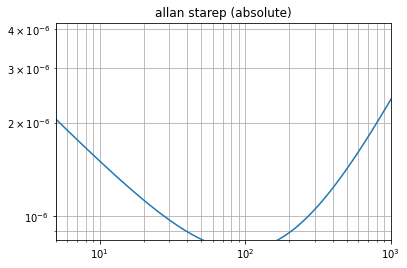

1.369321275846202e-06 1.506313849938582e-06
-8.324379255992896e-06 6.812570975275447e-06 -0.000487241711295668 -4.8724171129566803e-08


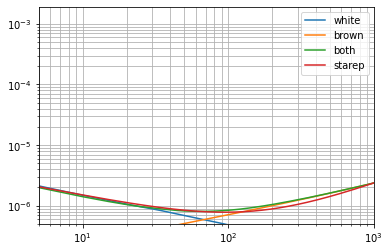

In [3]:
# starep
# it is originally 21 from the data, I adjusted it to 10 kind of arbitrary to get the observed phase
# jitter in axial phase measurements we experimentally observed.
data_scale =  21 #10 #21 #1 
# white noise
s1p0 = (10, 7.0e-8*data_scale)
s1p1 = (33, 4.0e-8*data_scale)
# brown noise
s2p0 = (200, 2.5e-8*data_scale)
s2p1 = (1000, 1.05e-7*data_scale)
off = 0
starep = createallan(s1p0, s1p1, s2p0, s2p1, off)
x = np.linspace(1, 1000000, 1000000)
plt.loglog(x, starep(x))
plt.grid(which="both")
plt.xlim(5, 1e3)
plt.ylim(4e-8*data_scale, 2e-7*data_scale)
plt.title('allan starep (absolute)')
plt.show()

# crosscheck
time_step = 5
rate = 1/time_step
data_size = 10000
white = starep(time_step)*normal(size=data_size)*1.05
print(starep(1)/np.sqrt(10), starep(10))
print(white.min(), white.max(), white.sum(), white.mean())
#plt.hist(white)
#plt.show()
#white += 21.1
#white /= 21.1
time = np.arange(0, time_step*data_size, time_step)
(t2, ad, ade, adn) = at.oadev(white, rate=rate, data_type="freq", taus=time)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='white')
brown = np.asarray([np.sum(white[:i])/np.sqrt(1500)*time_step for i in range(len(white))])#/30
#brown += 21.1
(t2, ad, ade, adn) = at.oadev(brown, rate=rate, data_type="freq", taus=time)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='brown')
(t2, ad, ade, adn) = at.oadev(brown+white, rate=rate, data_type="freq", taus=time)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='both')
plt.loglog(x, starep(x), label='starep')
plt.xlim((5, 1000))
plt.ylim((5e-7, None))
plt.grid(which="both")
plt.legend()
plt.show()



## FS725 10MHz reference
This is a relative allan plot, from the vendor.

![starep_allanplot](FS725.gif)

### Lets try to mimik this :)

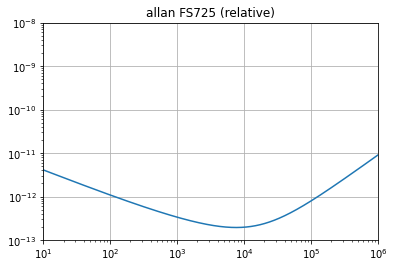

In [4]:
# 10MHz standard FS725
# white noise
s1p0 = (10, 4e-12)
s1p1 = (100, 1e-12)
# brown noise
s2p0 = (1e5, 7e-13)
s2p1 = (1e6, 9e-12)
# offset
off = 0.8e-13
fs725 = createallan(s1p0, s1p1, s2p0, s2p1, off)
plt.loglog(x, fs725(x))
plt.grid()
plt.xlim(10, 1e6)
plt.ylim(1e-13, 1e-8)
plt.title('allan FS725 (relative)')
plt.show()

## We also need a function to get the readout jitter from a specific SNR

[173.71491671  -0.23428251   3.6223825 ]


C:\Users\door\AppData\Roaming\Python\Python37\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


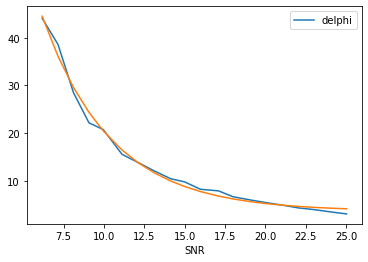

In [5]:
# Sascha Rau simulated this data set :)
snr = pd.read_csv("phasejitter_vs_SNR.txt", sep="\t")
snr.plot(x='SNR', y='delphi')
def expofit(x, a, b, c):
    return a*np.exp(b*x)+c
p, pcov = curve_fit(expofit, snr.SNR, snr.delphi, p0=[100, -1, 1])
print(p)
# partial is so usefull ;)
SNRjitter = partial(expofit, a=p[0], b=p[1], c=p[2])
plt.plot(snr.SNR, SNRjitter(snr.SNR))
plt.show()

# PHASE JITTER

In [6]:
def other_unwrap(phiarr):
    n = len(phiarr)
    arr = np.unwrap(phiarr)%(2*np.pi)
    std1 = np.std(arr)
    arr2 = (arr+np.pi)%(2*np.pi)
    std2 = np.std(arr2)
    if std1 < std2:
        return arr
    else:
        return arr2

In [7]:
def calc_evolved_phases(r0_exc, y0, x0, w, Dw, Tevol, z0y, z0x, wz, z0_exc=0, verbose=True):
    # calculate final PHASES
    # calculate the angle as atan(y,x), where y and x are calculated as r0*sin(vp*Tevol+phi0)
    # phip contains phase jitter which come in both from phase and frequency jitters
    # atan2 translate the angle from the x and y components. So this np.sin(angle) gives
    # amplitude in the y component
    # if z0_exc!=0 you have to add the dwz to the wz before calling this function
    
    # 1st: just the plain phase jitter without frequency shifts due to trap parameters:
    evolved_y0 = r0_exc * np.sin( w*Tevol + np.arctan2(y0, x0) )
    evolved_x0 = r0_exc * np.cos( w*Tevol + np.arctan2(y0, x0) )
    phi0 = np.arctan2( evolved_y0,  # y axial component
                       evolved_x0 ) # x axial component
    #phi0_jitter = np.std( np.unwrap(phi0)%(2*np.pi) )
    phi0_jitter = np.std( other_unwrap(phi0) )
    
    # 2nd: now with frequency shifts due to c4,c6,b2,relativistic
    evolved_y = r0_exc * np.sin( (Dw + w)*Tevol + np.arctan2(y0, x0) )
    evolved_x = r0_exc * np.cos( (Dw + w)*Tevol + np.arctan2(y0, x0) )
    phiwoX = np.arctan2( evolved_y,   #y
                         evolved_x )  #x
    #phiwoX_jitter = np.std( np.unwrap(phiwoX)%(2*np.pi) )
    phiwoX_jitter = np.std( other_unwrap(phiwoX) )
    
    # 3rd: if axial excitation and not cooling, we have to consider its phase evaluation too
    # for the radials (due to conversion)
    if z0_exc != 0:
        z0y = z0_exc * np.sin( (wz)*Tevol + np.arctan2(z0y, z0x) )
        z0x = z0_exc * np.cos( (wz)*Tevol + np.arctan2(z0y, z0x) )
    
    # 3rd: now also add some noise contribution from the random axial phase when converting (PnA specific!)
    # TODO: these x/y axial components are PnA stuff, dont know how they would look for PnP
    if np.mean(w)>np.mean(wz): # cyclotron 
        evolved_yX = evolved_y + z0y/np.sqrt(w/wz)
        evolved_xX = evolved_x + z0x/np.sqrt(w/wz)
    elif np.mean(w)==np.mean(wz): # this might be different as well (neither PnP nor PnA, just phase + cooling)
        if verbose: print("Axial PnP!!!")
        evolved_yX = evolved_y 
        evolved_xX = evolved_x 
    else: # magnetron
        evolved_yX = evolved_y + z0y/np.sqrt(wz/w)
        evolved_xX = evolved_x + z0x/np.sqrt(wz/w)
    phi = np.arctan2( evolved_yX,   #y
                      evolved_xX )  #x
    
    #phi_jitter = np.std( np.unwrap(phi)%(2*np.pi) )
    phi_jitter = np.std( other_unwrap(phi) )
    r = np.sqrt( evolved_yX**2 + evolved_xX**2 )

    if verbose: 
        print('evolved phase std phi0', phi0_jitter*180/np.pi)
        print('evolved phase std phi without PnA', phiwoX_jitter*180/np.pi)
        print('evolved phase std phi ', phi_jitter*180/np.pi)

    return phi0, phiwoX, phi, r, phi0_jitter, phiwoX_jitter, phi_jitter, phi

In [121]:
def print_n_plot(ftype, results, SNR_jitter, SNR_val, Dwp, evol_time, excradius_p,
                 r0p, r0p_exc, phip_init, phip_exc,
                 nu10stability, starepstability, magfieldstability, 
                 save=False, verbose=False, show=False, alpha=0.3):
    
    phip0, phipwoX, phip, rp, phip0_jitter, phipwoX_jitter, phip_jitter, phip_arr = results

    # strings and add all together
    phip_val = str(int(phip_jitter*180/np.pi*10)/10)+'°'
    phipFIN = np.sqrt(SNR_jitter**2 + (phip_jitter*180/np.pi)**2)
    phipFIN_val = str(int(phipFIN*10)/10)+'°'

    if verbose:
        print('phase jitter (phi0, uncorr) [°]:', phip0_jitter*180/np.pi )
        print('phase jitter (only freq)    [°]:', np.std(Dwp)/2/np.pi*360*evol_time )
        print('phase jitter (phi, corr)    [°]:', phip_jitter *180/np.pi)
        #print('diff corr - uncorr          [°]:', (phip_jitter - phip0_jitter)*180/np.pi)
        print('phase jitter (SNR)          [°]:', SNR_jitter)
        print('phase jitter ( all )        [°]:', phipFIN)

    if show: 
        # some additional values needed for plots and prints...
        phip_mean = np.mean( np.unwrap(phip) )
        rp_mean = np.mean(rp)
        xpmean = rp_mean * np.cos(phip_mean)
        ypmean = rp_mean * np.sin(phip_mean)
        name = ion +'_'+ str(excradius_p*1e6) +'um_'+ str(evol_time) + 's_' + ftype

        # polar plot
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))
        ax.scatter(phip_init*2*np.pi, r0p*1e6, alpha=alpha, label='init')
        ax.scatter(phip_exc, r0p_exc*1e6, alpha=alpha, label='excited')
        ax.scatter(phip0, r0p_exc*1e6, alpha=alpha, label='at Tevol')
        ax.scatter(phip, rp*1e6, alpha=alpha, label='at Tevol + shifts')
        #print(rp_mean, phip_mean)
        # formatting
        ax.set_rlabel_position(135)  # Move radial labels away from plotted line
        ax.set_ylim(0, excradius_p*1.2*1e6)
        plt.thetagrids(range(0, 360, 15))
        ax.set_title(name+' // +SNR('+str(SNR)+ ')='+SNR_val+' // sum='+phipFIN_val +
                    '\n nu10: ' + str(nu10stability) +
                    ' // starep: ' + str(starepstability) +
                    ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
        plt.annotate(r'$\phi$ jitter '+phip_val, (phip_mean, rp_mean*1e6))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                   fancybox=True, shadow=True, ncol=5)
        fig.tight_layout()
        # save plot
        name += '_'+str(int(nu10stability))+str(int(starepstability))+str(int(magfieldstability))
        if save:
            fig.savefig(name+'.png', dpi=100)
            #fig.savefig(name+'.svg')
        plt.show()
        #plt.clf()

In [185]:
      
    
def delphi(ion='187Re29+', vres=500e3, TR=0.88, evol_time=40, SNR=16,
            excradius_p = 20e-6, excradius_z = 0, excradius_m = 0,
            meas_gap_time = 20, magfieldstability=False, nu10stability=True,
            starepstability=False, evol_time_ref=0.1, bdrift_per_second=0,
            Tz=5, Tp=None, B0=7, B1=1.41e-6, B2=6.4e-2, C2=-1.496e4,
            d4=8.88e-4, TRC4=0.880143, d6=-6.1e-5, TRC6=0.87860,
            theta = 0, thetastability=False, # in radians
            average_pzm=[False, True, False], # See Note 1
            simcount=1e1, verbose=True, show=False, save=False, sumplot=False, alpha=0.3):
    """
    Note1: 
    Typically the axial amplitude is not a fixed pick out of the thermal distribution during the PAT, 
    it is in constant interaction with the resonator and thereby averages to the mean thermal axial amplitude every time.
    How precise it averages down is discussable though: The change in the axial amplitude is proportional to the ions 
    cooling time and the longer the PAT the better the average should be. I did not try to quantify that though.
    """
    # inital conversions
    simcount = int(simcount)
    C4 = itp.dc4(TR-TRC4, d4)*1e12 # yes, i do work in meters here o.O
    C6 = itp.dc6(TR-TRC6, d6)*1e18
    if verbose: print(' C4', C4, '\n C6', C6, '\n Tevol', evol_time)

    m, q = re.findall(r'\d+', ion)
    m = int(m)
    q = int(q)
    if verbose: print('mass, charge', m, q)

    # add noise to simulation parameters like U, B0, nu10
    #
    # NOTE: The starep and nu10 jitter are not 100% correct, but ok.
    # Explaination:
    # We take the evolution time and pick the stability for that evolution time from
    # the allan deviation. The Problem with that is, that this considers only the
    # stability you can reach averaging over that time (evolution time) but for a 
    # set of samples from sequential measurements, each with gaps of, idk, ~20s for 
    # measuring the reference phase and cooling, there would be a lot(!) of brown noise
    # (drift) of the actual voltage adding up from measurement to measurement.
    # If we would include this though for something like 1000 simulated phases, chances
    # are high (pretty much certainty) that these drift would leave you with a 360 degree
    # distrubtion of phases at least for the starep jitter. And since this would be hours
    # of measurement time and we only ever average 10 phases we dont really need this anyway,
    # we just want an estimation on the 'short-term' jitter over ~10 phases with a lot
    # of simulated phases to get a more precise value for that estimate. For that we just use
    # white noise and dont care about eventual brown noise.
    # 
    # NOTE2:
    # For the magnetic field jitter we have no real information like allan plots. But for
    # estimation of specific jitters would do to your stability you can just add the relative
    # stability as a value to check.
    #
    # TODO: consider the magnetic field sensors as a data source to create an allan
    # plot (/50 /7)
    U0 = itp.U0(q, m, vres, c2=C2)
    Tevol = evol_time
    if starepstability:
        # this is an absolute allan plot, since the starep currently has this behavior
        # that the output noise is not dependend on the output value.
        # TODO: this all gets 'on top' rand gives 0...1 random values, actually better
        # would be -1...1 since the value from starep is peak to peak. But it is not
        # that relavant in the end... we just do *2 for now...
        if isinstance(starepstability, float) and starepstability < 0.001:
            #white2 = starepstability*normal(size=simcount)*U0
            white = np.random.normal(0, starepstability, size=simcount)*U0
        elif isinstance(starepstability, float):
            white = starep(Tevol)*normal(size=simcount)*1.1*starepstability
        else:
            white = starep(Tevol)*normal(size=simcount)*1.1#*np.sqrt(2)
        #U02 = U0 + white2
        U0 = U0 + white
        if verbose:
            print('starep mean/std', np.mean(U0), np.std(U0))
            plt.plot(U0, label="U0")
            #plt.plot(U02, label="U02")
            plt.legend()
            plt.show()

        
        #plt.hist(U0)
        #plt.show()
    if nu10stability:
        # this is a ralitve allan plot, so the fs725(Tevol) is delnu/nu.
        # This relative stability directly translates to the delTevol = delnu/nu * Tevol
        white = fs725(evol_time)*normal(size=simcount)*evol_time
        Tevol = evol_time + white
        if verbose: print('Tevol mean/std', np.mean(Tevol), np.std(Tevol))
        #plt.hist(Tevol)
        #plt.show()
    if magfieldstability:
        white = magfieldstability*normal(size=simcount)*B0
        B0 = white + B0
        
    if thetastability:
        theta = thetastability*normal(size=simcount) + theta
        
    # magfield drift
    if bdrift_per_second != 0:
        step = bdrift_per_second * (evol_time + 20)
        drift = np.arange(0, simcount*step, step)
        if len(drift) < simcount:
            drift = drift.append(drift[-1]+step)
        elif len(drift) > simcount:
            drift = drift[:-1]
        B0 = B0 + drift

    # SNR phase jitter (just for print)
    SNR_jitter = SNRjitter(SNR) # function from cell way above
    SNR_val = str(int(SNR_jitter*10)/10)+'°'
        
    # calc frequencies
    vc = itp.omegac(q, m, B0) /pi2
    vz = itp.omegaz(q, m, U0, C2, nominal = True) /pi2
    vp = itp.omegap(vc*pi2, vz*pi2, nominal = True) /pi2
    vm = itp.omegam(vc*pi2, vz*pi2, nominal = True) /pi2
    if verbose: 
        print('frequencies:', '\n nu_c:', "{:.2e}".format(np.mean(vc)), '\n nu_p:', "{:.2e}".format(np.mean(vp)),
            '\n nu_z:', "{:.2e}".format(np.mean(vz)), '\n nu_m:', "{:.2e}".format(np.mean(vm)))
        print('freq stds:', '\n nu_c:', "{:.2e}".format(np.std(vc)), '\n nu_p:', "{:.2e}".format(np.std(vp)),
            '\n nu_z:', "{:.2e}".format(np.std(vz)), '\n nu_m:', "{:.2e}".format(np.std(vm)))

        plt.hist(vz, label='vz', alpha=alpha, color='b', bins=100)
        #plt.hist(z0r*1e6, label='z0r', alpha=0.5, color='r', bins=100)
        plt.legend()
        plt.show()
        plt.hist(vm, label='vm', alpha=alpha, color='b', bins=100)
        #plt.hist(z0r*1e6, label='z0r', alpha=0.5, color='r', bins=100)
        plt.legend()
        plt.show()
    # random phases in all modes
    # TODO: do i need deep copies here for the init arrays?
    phip=rand(simcount)
    phip_init=phip
    phim=rand(simcount)
    phim_init=phim
    phiz=rand(simcount)
    phiz_init=phiz

    # thermal energy picked from distribution and calc radii
    if Tp is None:
        Tp = Tz * np.mean(vp)/np.mean(vz)
    if verbose: print('Tp=', Tp)
    E0p = exponential(kb*Tp, simcount)
    # TODO why? this was commented out in the original code as well, no idea...
    #%E0p=-log(rand(simcount,Dvp1))/vz*vp*kb*T;
    r0p = np.sqrt(2*E0p/kgu/m/(pi2*vp)**2) # Das sind tatsächlich die Einzelradien
    #r0p_alt = itp.rohp(E0p/eVJ, pi2*vp, vm*pi2, m)
    #print('diffrence in rho calc:', np.mean(r0p-r0p_alt), np.std(r0p-r0p_alt))
    if average_pzm[0]: r0p = np.full(len(r0p), np.mean(r0p))
    if verbose: print('mean/std thermal rho_p', np.mean(r0p), np.std(r0p))
        
    # same for magnetron...
    Tm = Tz * np.mean(vm)/np.mean(vz)
    #Tm = 10 * np.mean(vm)/np.mean(vz)
    if verbose: print('Tm=', Tm)
    E0m = exponential(kb*Tm, simcount)
    #r0m=sqrt(4*E0m/(2*pi*vz)^2/mu/mp);
    # TODO: also compare my functions here with the ones from Sascha.
    r0m = np.sqrt(4*E0m/kgu/m/(2*np.pi*vz)**2) #
    if average_pzm[2]: r0m = np.full(len(r0m), np.mean(r0m))
    if verbose: print('mean/std thermal rho_m', np.mean(r0m), np.std(r0m))

    # and axial...
    E0z = exponential(kb*Tz, simcount)
    #z0r=sqrt(2*E0z/mu/mp/(2*pi*vz)^2);
    z0r = np.sqrt(2*E0z/kgu/m/(2*np.pi*vz)**2)
    #print("thermal z easy", np.sqrt(2*kb*Tz/m/kgu/(2*np.pi*vz)**2) )
    if average_pzm[1]: z0r = np.full(len(z0r), np.mean(z0r))
    if verbose: 
        print('mean/std thermal z', np.mean(z0r), np.std(z0r))
        plt.hist(r0m*1e6, label='r0m', alpha=alpha, color='b', bins=100)
        plt.hist(r0p*1e6, label='r0p', alpha=alpha, color='g', bins=100)
        #plt.hist(z0r*1e6, label='z0r', alpha=0.5, color='r', bins=100)
        plt.legend()
        plt.show()
        #plt.hist(E0m*1e6, label='r0m', alpha=0.5, color='b', bins=100)
        #plt.legend()
        #plt.show() 
        #plt.hist(E0p*1e6, label='r0p', alpha=0.5, color='g', bins=100)
        #plt.legend()
        #plt.show()
        #plt.hist(E0z*1e6, label='z0r', alpha=0.5, color='r', bins=100)
        #plt.legend()
        #plt.show() 

    # switch coordinate system and add excitation radii
    x0p = r0p*np.cos(phip*2*np.pi) + excradius_p
    x0p0 = r0p*np.cos(phip*2*np.pi)
    y0p = r0p*np.sin(phip*2*np.pi)
    x0m = r0m*np.cos(phim*2*np.pi) + excradius_m
    y0m = r0m*np.sin(phim*2*np.pi)
    z0x = z0r*np.cos(phiz*2*np.pi) + excradius_z
    z0y = z0r*np.sin(phiz*2*np.pi)
    # and switch back :D
    r0p_exc = np.sqrt(x0p**2 + y0p**2)
    phip_exc = np.arctan2( y0p, x0p )
    r0m_exc = np.sqrt(x0m**2 + y0m**2)
    phim_exc = np.arctan2( y0m, x0m )
    z0r_exc = np.sqrt(z0x**2 + z0y**2)
    phiz_exc = np.arctan2( z0y, z0x )
    
    if verbose: 
        print('mean/std r0p_exc', np.mean(r0p_exc), np.std(r0p_exc))
        print('mean/std r0m_exc', np.mean(r0m_exc), np.std(r0m_exc))
        print('mean/std z0r_exc', np.mean(z0r_exc), np.std(z0r_exc))

    # calculate frequency shift for axial 
    dzc4 = sys.domegaz_c4(z0r_exc, r0p_exc, r0m_exc, vz*2*np.pi, C4, C2)
    dzc6 = sys.domegaz_c6(z0r_exc, r0p_exc, r0m_exc, vz*2*np.pi, C6, C2)
    dzb2 = sys.domegaz_b2(r0p_exc, r0m_exc, vz*2*np.pi, vp*2*np.pi, vm*2*np.pi, B2, B0)
    dzrel = sys.domegaz_rel(r0p_exc, z0r_exc, r0m_exc, vp*2*np.pi, vz*2*np.pi, vm*2*np.pi)
    dztheta = sys.domegaz_tilt_ellip(vz*2*np.pi, epsilon=0, theta=theta, phi=0)

    Dwz = dzc4 + dzc6 + dzb2 + dzrel + dztheta
    if verbose:
        print('axial frequency shift c4  (mean/std):', np.mean(dzc4)/2/np.pi, np.std(dzc4)/2/np.pi)
        print('axial frequency shift c6  (mean/std):', np.mean(dzc6)/2/np.pi, np.std(dzc6)/2/np.pi)
        print('axial frequency shift b2  (mean/std):', np.mean(dzb2)/2/np.pi, np.std(dzb2)/2/np.pi)
        print('axial frequency shift rel (mean/std):', np.mean(dzrel)/2/np.pi, np.std(dzrel)/2/np.pi)
        print('axial frequency shift sum (mean/std):', np.mean(Dwz)/2/np.pi, np.std(Dwz)/2/np.pi)
        plt.hist(Dwz/2/np.pi, label='Dwz', alpha=alpha, color='b', bins=100)
        #plt.hist(z0r*1e6, label='z0r', alpha=0.5, color='r', bins=100)
        plt.legend()
        plt.show()
        
    # calculate frequency shift for cyclotron 
    dpc4 = sys.domegap_c4(z0r_exc, r0p_exc, r0m_exc, vp*2*np.pi, vm*2*np.pi, C4, C2)
    dpc6 = sys.domegap_c6(z0r_exc, r0p_exc, r0m_exc, vp*2*np.pi, vm*2*np.pi, C6, C2)
    dpb2 = sys.domegap_b2(r0p_exc, r0m_exc, z0r_exc, vp*2*np.pi, vm*2*np.pi, B2, B0)
    dprel = sys.domegap_rel(r0p_exc, z0r_exc, r0m_exc, vp*2*np.pi, vz*2*np.pi, vm*2*np.pi)
    dptheta = sys.domegap_tilt_ellip(vp*2*np.pi, vz*2*np.pi, vm*2*np.pi, epsilon=0, theta=theta, phi=0)    
    
    Dwp = dpc4 + dpc6 + dpb2 + dprel + dptheta
    if verbose:
        print('cyclo frequency shift c4  (mean/std):', np.mean(dpc4)/2/np.pi, np.std(dpc4)/2/np.pi)
        print('cyclo frequency shift c6  (mean/std):', np.mean(dpc6)/2/np.pi, np.std(dpc6)/2/np.pi)
        print('cyclo frequency shift b2  (mean/std):', np.mean(dpb2)/2/np.pi, np.std(dpb2)/2/np.pi)
        print('cyclo frequency shift rel (mean/std):', np.mean(dprel)/2/np.pi, np.std(dprel)/2/np.pi)
        print('cyclo frequency shift sum (mean/std):', np.mean(Dwp)/2/np.pi, np.std(Dwp)/2/np.pi)

    # calculate frequency shift for magnetron 
    dmc4 = sys.domegam_c4(z0r_exc, r0p_exc, r0m_exc, vp*2*np.pi, vm*2*np.pi, C4, C2)
    dmc6 = sys.domegam_c6(z0r_exc, r0p_exc, r0m_exc, vp*2*np.pi, vm*2*np.pi, C6, C2)
    dmb2 = sys.domegam_b2(r0p_exc, r0m_exc, z0r_exc, vp*2*np.pi, vm*2*np.pi, B2, B0)
    dmrel = sys.domegam_rel(r0p_exc, z0r_exc, r0m_exc, vp*2*np.pi, vz*2*np.pi, vm*2*np.pi)
    dmtheta = sys.domegam_tilt_ellip(vp*2*np.pi, vz*2*np.pi, vm*2*np.pi, epsilon=0, theta=theta, phi=0)    
    
    Dwm = dmc4 + dmc6 + dmb2 + dmrel + dmtheta
    if verbose:
        print('magne frequency shift c4  (mean/std):', np.mean(dmc4)/2/np.pi, np.std(dmc4)/2/np.pi)
        print('magne frequency shift c6  (mean/std):', np.mean(dmc6)/2/np.pi, np.std(dmc6)/2/np.pi)
        print('magne frequency shift b2  (mean/std):', np.mean(dmb2)/2/np.pi, np.std(dmb2)/2/np.pi)
        print('magne frequency shift sum (mean/std):', np.mean(Dwm)/2/np.pi, np.std(Dwm)/2/np.pi)

    # evolved phases for cyclotron
    p_results = calc_evolved_phases(r0p_exc, y0p, x0p, vp*2*np.pi, Dwp, Tevol, z0y, z0x, (vz*2*np.pi)+Dwz, 
                                    verbose=verbose)
    phip0, phipwoX, phip, rp, phip0_jitter, phipwoX_jitter, phip_jitter, phip_arr = p_results
    
    #plt.clf()
    #plt.hist(np.unwrap(phip_arr)%(2*np.pi)*180/np.pi)
    #plt.show()
    
    if excradius_p != 0:
        print_n_plot('vp', p_results, SNR_jitter, SNR_val, Dwp, evol_time, excradius_p, 
                     r0p, r0p_exc, phip_init, phip_exc,
                     nu10stability, starepstability, magfieldstability,
                     save, verbose, show, alpha=alpha)
    
    # evolved phases for magnetron
    m_results = calc_evolved_phases(r0m_exc, y0m, x0m, vm*2*np.pi, Dwm, Tevol, z0y, z0x, (vz*2*np.pi)+Dwz, 
                                    excradius_z, verbose=verbose)
    phim0, phimwoX, phim, rm, phim0_jitter, phimwoX_jitter, phim_jitter, phim_arr = m_results
    
    if excradius_m != 0:
        print_n_plot('vm', m_results, SNR_jitter, SNR_val, Dwm, evol_time, excradius_m, 
                     r0m, r0m_exc, phim_init, phim_exc,
                     nu10stability, starepstability, magfieldstability,
                     save, verbose, show, alpha=alpha)

        if verbose:
            plt.hist(rm*1e6, label='rm', alpha=alpha, color='b', bins=100)
            #plt.hist(z0r*1e6, label='z0r', alpha=0.5, color='r', bins=100)
            plt.legend()
            plt.show()
    
    # evolved phases for axial
    z_results = calc_evolved_phases(z0r_exc, z0y, z0x, vz*2*np.pi, Dwz, Tevol, 0, 0, (vz*2*np.pi)+Dwz, 
                                    verbose=verbose)
    phiz0, phizwoX, phiz, rz, phiz0_jitter, phizwoX_jitter, phiz_jitter, phiz_arr = m_results


    if excradius_z != 0:
        print_n_plot('vz', z_results, SNR_jitter, SNR_val, Dwz, evol_time, excradius_z, 
                     z0r, z0r_exc, phiz_init, phiz_exc,
                     nu10stability, starepstability, magfieldstability,
                     save, verbose, show, alpha=alpha)
    

    # now lets get frequency results and apply invariance
    # TODO: if we really do everything like in the analysis we would need to
    # add the referance phase jitter due to the difference delphi_long - delphi_ref
    # TODO:
    if sumplot:
        phase_sum = other_unwrap(other_unwrap(phip) + other_unwrap(phim))
        phase_diff = other_unwrap(other_unwrap(phip) - other_unwrap(phim))
        phis_val = str(int(np.std(phase_sum)*180/np.pi*10)/10)+'°'
        phid_val = str(int(np.std(phase_diff)*180/np.pi*10)/10)+'°'

        # some additional values needed for plots and prints...
        phis_mean = np.mean( phase_sum )
        phid_mean = np.mean( phase_diff )
        rp_mean = np.mean(rm)
        #xpmean = rp_mean * np.cos(phip_mean)
        #ypmean = rp_mean * np.sin(phip_mean)
        name = ion +'_'+ str(excradius_m*1e6) +'um_'+ str(evol_time) + 's'

        # polar plot
        plt.clf()
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))
        ax.scatter(phip, rp*1e6, alpha=alpha, label='p at Tevol + shifts')
        ax.scatter(phim, rm*1e6, alpha=alpha, label='m at Tevol + shifts')
        ax.scatter(phase_sum, rm*1e6, alpha=alpha, label='p+m at Tevol + shifts')
        ax.scatter(phase_diff, rm*1e6, alpha=alpha, label='p-m at Tevol + shifts')

        #print(rp_mean, phip_mean)
        # formatting
        ax.set_rlabel_position(135)  # Move radial labels away from plotted line
        ax.set_ylim(0, excradius_p*1.5*1e6)
        plt.thetagrids(range(0, 360, 15))
        ax.set_title(name+' // +SNR('+str(SNR)+ ')='+SNR_val + 
                    '\n nu10: ' + str(nu10stability) +
                    ' // starep: ' + str(starepstability) +
                    ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
        plt.annotate(r'$\phi sum$ jitter '+phis_val, (phis_mean, rp_mean*1e6))
        plt.annotate(r'$\phi diff$ jitter '+phid_val, (phid_mean, rp_mean*1e6))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                   fancybox=True, shadow=True, ncol=5)
        fig.tight_layout()
        # save plot
        name += '_'+str(int(nu10stability))+str(int(starepstability))+str(int(magfieldstability))
        plt.show()
    

    dvp_meas = other_unwrap(phip)/evol_time/pi2
    dvm_meas = other_unwrap(phim)/evol_time/pi2
    dvz_meas = other_unwrap(phiz)/evol_time/pi2
    #vp_meas = np.mean(vp) + dvp_meas
    #vm_meas = np.mean(vm) + dvm_meas
    #vz_meas = np.mean(vz) + dvz_meas
    vp_meas = vp + dvp_meas
    vm_meas = vm + dvm_meas
    vz_meas = vz + dvz_meas
    vc_meas = np.sqrt(vp_meas**2 + vz_meas**2 + vm_meas**2)
    if verbose: 
        print(len(vp), len(dvp_meas), len(vm), len(dvm_meas), len(vz), len(dvz_meas), len(vc_meas))
        print('dvp results:', np.mean(dvp_meas), np.std(dvp_meas), np.std(dvp_meas)/np.mean(dvp_meas))
        print('vp results:', np.mean(vp_meas), np.std(vp_meas), np.std(vp_meas)/np.mean(vp_meas))
        print('dvm results:', np.mean(dvm_meas), np.std(dvm_meas), np.std(dvm_meas)/np.mean(dvm_meas))
        print('vm results:', np.mean(vm_meas), np.std(vm_meas), np.std(vm_meas)/np.mean(vm_meas))
        print('dvz results:', np.mean(dvz_meas), np.std(dvz_meas), np.std(dvz_meas)/np.mean(dvz_meas))
        print('vz results:', np.mean(vz_meas), np.std(vz_meas), np.std(vz_meas)/np.mean(vz_meas))
        print('vc results:', np.mean(vc_meas), np.std(vc_meas), np.std(vc_meas)/np.mean(vc_meas))
    

            
    phip_SNR = phip + SNR_jitter/180*np.pi*(normal(size=simcount)-0.5)*2
    phipSNR_jitter = np.std( other_unwrap(phip_SNR) )
    dvp_measSNR = phip_SNR/evol_time/pi2
    vp_measSNR = np.mean(vp) + dvp_measSNR
    vc_measSNR = np.sqrt(vp_measSNR**2 + vz**2 + vm**2)
        
    data = {
        'phip0': phip0_jitter,
        'phip' : phip_jitter,
        'phipSNR' : phipSNR_jitter,
        'phim0' : phim0_jitter,
        'phim' : phim_jitter,
        'phiz0' : phiz0_jitter,
        'phiz' : phiz_jitter,
        'SNR'  : SNR_jitter,
        'vp_jitter' : np.std(vp_meas),
        'vp_precision': np.std(vp_meas)/np.mean(vp_meas),
        'vm_jitter' : np.std(vm_meas),
        'vm_precision': np.std(vm_meas)/np.mean(vm_meas),
        'vz_jitter' : np.std(vz_meas),
        'vz_precision': np.std(vz_meas)/np.mean(vz_meas),
        'vc_jitter' : np.std(vc_meas),
        'vc_precision': np.std(vc_meas)/np.mean(vc_meas),
        'vpSNR_jitter' : np.std(vp_measSNR),
        'vpSNR_precision': np.std(vp_measSNR)/np.mean(vp_measSNR),
        'vcSNR_jitter' : np.std(vc_measSNR),
        'vcSNR_precision': np.std(vc_measSNR)/np.mean(vc_measSNR),
        'results_p': p_results,
        'results_m': m_results,
        'results_z': z_results,
    }
    
    return phip_jitter, phip_jitter*180/np.pi, data
    #return all/180*np.pi, all, all/360


In [231]:
# Choose your weapon

ion = '163Ho39+'
#ion = '163Ho32+'
#ion = '20Ne10+'
#ion = '187Re29+'
ion = '172Yb42+'
#ion = '172Yb45+'
#ion = '12C3+'
#ion = '3He2+'
#ion = '12C6+'
#ion = '4He2+'
#ion = '9Be3+'
#ion = '1H1+'
#ion = '40Ca10+'
#ion = '12C5+'
ion = '12C6+'
#ion = '4He2+'
#ion = '20Ne10+'

SNR = 16
Tz= 2

#Tz= 7 # alphatrap
Tp= None # None for pentatrap
B2 = 6e-2 #1e-5# pentatrap = 6e-2
exc_radius = 30e-6
TR_set = 0.8801 #0.8801#9

B0 = 7.0 #1.98 #base = 2, pentatrap =7, alphatrap =4
#B0 = 4.0 #1.98 #base = 2, pentatrap =7, alphatrap =4

 C4 -38192.88000005816 
 C6 -91499389999.99362 
 Tevol 0.1
mass, charge 12 6
starep mean/std -6.196989386060134 6.190422346611614e-08


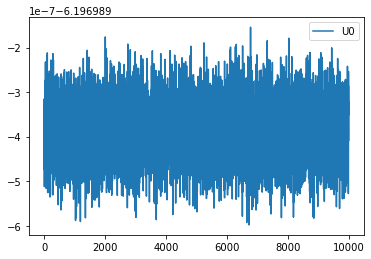

Tevol mean/std 0.10000000000010205 6.409349470713608e-12
frequencies: 
 nu_c: 5.37e+07 
 nu_p: 5.37e+07 
 nu_z: 4.76e+05 
 nu_m: 2.11e+03
freq stds: 
 nu_c: 1.61e-03 
 nu_p: 1.61e-03 
 nu_z: 2.38e-03 
 nu_m: 2.11e-05


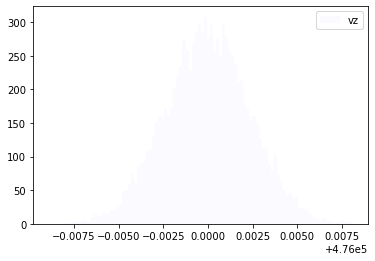

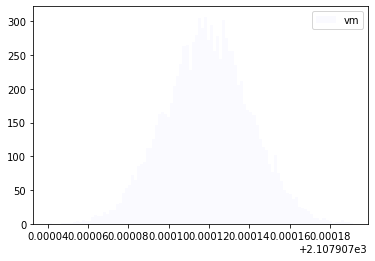

Tp= 225.81640132784779
mean/std thermal rho_p 1.4608429816612896e-06 7.683916628639925e-07
Tm= 0.008856752601846369
mean/std thermal rho_m 1.4788481869350871e-06 7.682781165440821e-07
mean/std thermal z 1.569571211771381e-05 3.3881317890172014e-21


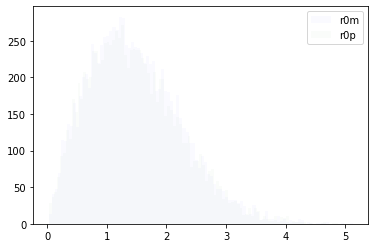

mean/std r0p_exc 3.0029534397383106e-05 1.1685966992643616e-06
mean/std r0m_exc 1.4788481869350871e-06 7.682781165440821e-07
mean/std z0r_exc 1.569571211771381e-05 3.5106015986440875e-21
axial frequency shift c4  (mean/std): -0.0014268078984501862 0.00012801251482313025
axial frequency shift c6  (mean/std): 3.312195548731481e-06 7.69907088049249e-07
axial frequency shift b2  (mean/std): 0.023488355325837606 0.0018244607482301295
axial frequency shift rel (mean/std): -0.0001363614222667549 1.0591720581609073e-05
axial frequency shift sum (mean/std): 0.021928498200669395 0.0016867269673578912


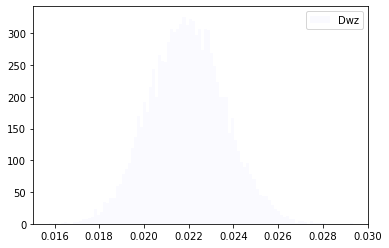

cyclo frequency shift c4  (mean/std): 3.3580365003647656e-06 5.683910569195277e-07
cyclo frequency shift c6  (mean/std): 7.866622730138495e-09 6.414134112124433e-10
cyclo frequency shift b2  (mean/std): -0.00015193024357283938 1.617681774794898e-05
cyclo frequency shift rel (mean/std): -0.03079368870052489 0.0023918780403058347
cyclo frequency shift sum (mean/std): -0.03094225304097464 0.0024074764058297023
magne frequency shift c4  (mean/std): -1.0626245435108456e-05 1.1329917806090212e-06
magne frequency shift c6  (mean/std): -1.4348865116333844e-14 1.6751475451088346e-13
magne frequency shift b2  (mean/std): 0.0002080446454077966 1.6160065039329087e-05
magne frequency shift sum (mean/std): 0.00019741849469704568 1.5027315938998511e-05
evolved phase std phi0 2.2301467022340056
evolved phase std phi without PnA 2.231657482253281
evolved phase std phi  2.9930221187095176
phase jitter (phi0, uncorr) [°]: 2.2301467022340056
phase jitter (only freq)    [°]: 0.0866691506098693
phase jitter

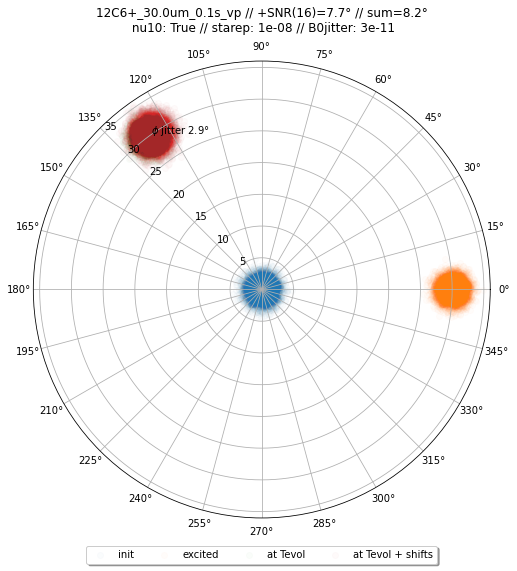

evolved phase std phi0 103.7637681110707
evolved phase std phi without PnA 103.7637677054632
evolved phase std phi  103.86462893671032
evolved phase std phi0 103.6936051322055
evolved phase std phi without PnA 103.69877943289796
evolved phase std phi  103.69877943289796
10000 10000 10000 10000 10000 10000 10000
dvp results: 8.483089997627726 0.0831395032974866 0.009800615497505783
vp results: 53744311.99606161 0.08320290896149247 1.548124924691372e-09
dvm results: 5.0161760541375235 2.8851285815752865 0.5751649364849402
vm results: 2112.9232951737076 2.8851284863009825 0.001365467687772258
dvz results: 5.0161760541375235 2.8851285815752865 0.5751649364849402
vz results: 476005.0161489864 2.8851187952848725 6.061110066919651e-06
vc results: 53746419.94747066 0.09072259619226292 1.6879746833543726e-09


(0.052238090556497654,
 2.9930221187095176,
 {'phip0': 0.038923402756476974,
  'phip': 0.052238090556497654,
  'phipSNR': 0.27312455453360684,
  'phim0': 1.811019397814081,
  'phim': 1.8127797513077721,
  'phiz0': 1.811019397814081,
  'phiz': 1.8127797513077721,
  'SNR': 7.713816135258506,
  'vp_jitter': 0.08320290896149247,
  'vp_precision': 1.548124924691372e-09,
  'vm_jitter': 2.8851284863009825,
  'vm_precision': 0.001365467687772258,
  'vz_jitter': 2.8851187952848725,
  'vz_precision': 6.061110066919651e-06,
  'vc_jitter': 0.09072259619226292,
  'vc_precision': 1.6879746833543726e-09,
  'vpSNR_jitter': 0.4346912293142248,
  'vpSNR_precision': 8.08813538271191e-09,
  'vcSNR_jitter': 0.4346743882489266,
  'vcSNR_precision': 8.087504827118395e-09,
  'results_p': (array([2.2537369 , 2.19810535, 2.19161808, ..., 2.25297055, 2.17501219,
          2.14294097]),
   array([2.23377442, 2.17666711, 2.17141496, ..., 2.23517362, 2.15487835,
          2.12454753]),
   array([2.28177079, 2.20894

In [232]:
# lets test :)
tevol = 0.1
#delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set-0.00001, verbose=True, show=True, simcount=1e5, average_pzm=[False, True, False], starepstability=True, magfieldstability=3e-11, sumplot=False)
delphi(ion=ion, vres=476e3, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set-0.00000001, verbose=True, show=True, simcount=1e4, average_pzm=[False, True, False], starepstability=1e-8, magfieldstability=3e-11, sumplot=False, alpha=0.02)


 C4 -8918184.000000022 
 C6 518500000000.0038 
 Tevol 100.1
mass, charge 12 6
starep mean/std -6.837649827127971 8.590144452181081e-07


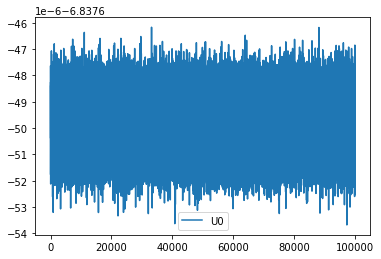

Tevol mean/std 100.10000000000029 1.0805328480958733e-10
frequencies: 
 nu_c: 5.37e+07 
 nu_p: 5.37e+07 
 nu_z: 5.00e+05 
 nu_m: 2.33e+03
freq stds: 
 nu_c: 1.62e-03 
 nu_p: 1.64e-03 
 nu_z: 3.14e-02 
 nu_m: 2.92e-04


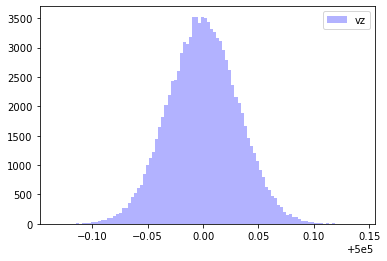

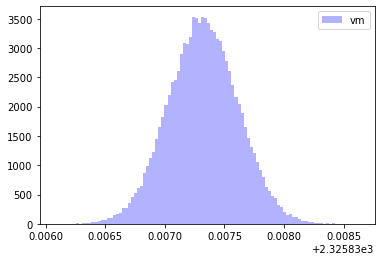

Tp= 214.97634229355805
mean/std thermal rho_p 1.4344704647281398e-06 7.495339988214218e-07
Tm= 0.009303349283285014
mean/std thermal rho_m 1.4365138807022277e-06 7.509083511159397e-07
mean/std thermal z 1.4895828408950306e-05 1.6940658945086007e-21


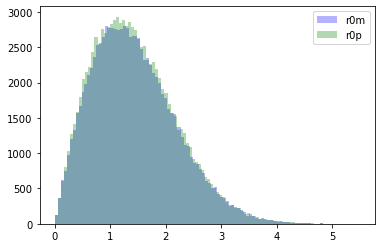

mean/std r0p_exc 1.4344704647281398e-06 7.495339988214218e-07
mean/std r0m_exc 0.00010000649076874107 1.1467488769422962e-06
mean/std z0r_exc 1.4895828408950306e-05 1.7867537134079975e-21
axial frequency shift c4  (mean/std): -4.423751558157061 0.10256507427129109
axial frequency shift c6  (mean/std): -0.004668551352541375 0.00021901107958566016
axial frequency shift b2  (mean/std): 7.557395547432321e-05 6.460729393676154e-05
axial frequency shift rel (mean/std): -4.1772817095072016e-07 4.1383814855859717e-07
axial frequency shift sum (mean/std): -4.428344953282299 0.10278291891376483


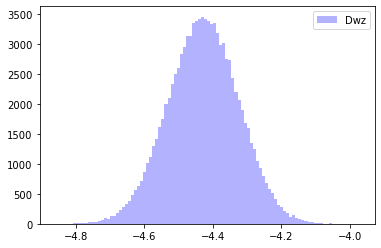

cyclo frequency shift c4  (mean/std): 0.04069054748761535 0.0009541798260174011
cyclo frequency shift c6  (mean/std): 4.141331227093988e-05 1.990461289198908e-06
cyclo frequency shift b2  (mean/std): -0.002253511219733445 5.284039921067181e-05
cyclo frequency shift rel (mean/std): -8.964250001520671e-05 8.896926182826939e-05
cyclo frequency shift sum (mean/std): 0.038388807080137644 0.0009069991515998747
magne frequency shift c4  (mean/std): -0.01989195472761988 0.0004772264706079857
magne frequency shift c6  (mean/std): -5.696588159648552e-10 2.8080010245865156e-11
magne frequency shift b2  (mean/std): 7.009355257238762e-07 6.011162464076162e-07
magne frequency shift sum (mean/std): -0.01989125436141782 0.00047720938212181783
evolved phase std phi0 103.58834163476591
evolved phase std phi without PnA 103.66751181595367
evolved phase std phi  103.65465889090414
evolved phase std phi0 10.548169078842832
evolved phase std phi without PnA 20.169401992511776
evolved phase std phi  20.17376

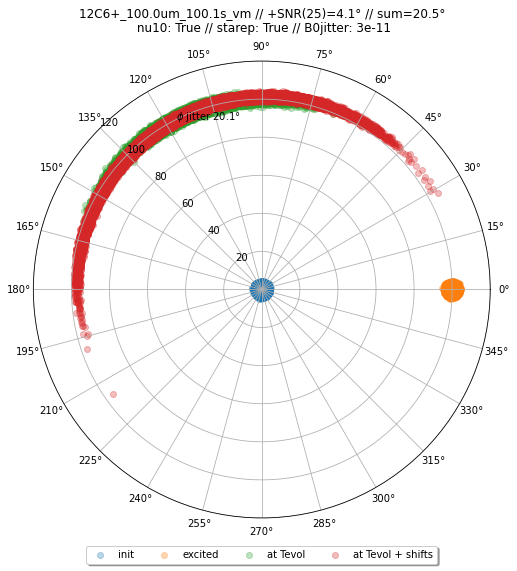

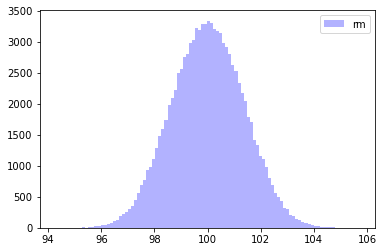

evolved phase std phi0 103.87626733214903
evolved phase std phi without PnA 103.86429260603035
evolved phase std phi  103.86429260603035
100000 100000 100000 100000 100000 100000 100000
dvp results: 0.004977123437262993 0.002876419660642251 0.5779281339713054
vp results: 53744085.58773499 0.003308232329062255 6.15552817186126e-11
dvm results: 0.00324417763295101 0.0005598224606096162 0.1725622095792527
vm results: 2325.840565404313 0.0007546057289286955 3.244443063523223e-07
dvz results: 0.00324417763295101 0.0005598224606096162 0.1725622095792527
vz results: 500000.00333133474 0.03170310583710983 6.340621125176502e-08
vc results: 53746411.425086334 0.0032958830366272606 6.132284833976646e-11


(1.8091150826778912,
 103.65465889090414,
 {'phip0': 1.8079576282073906,
  'phip': 1.8091150826778912,
  'phipSNR': 1.808969073727948,
  'phim0': 0.18410028048286478,
  'phim': 0.3520985727390594,
  'phiz0': 0.18410028048286478,
  'phiz': 0.3520985727390594,
  'SNR': 4.1191430651870125,
  'vp_jitter': 0.003308232329062255,
  'vp_precision': 6.15552817186126e-11,
  'vm_jitter': 0.0007546057289286955,
  'vm_precision': 3.244443063523223e-07,
  'vz_jitter': 0.03170310583710983,
  'vz_precision': 6.340621125176502e-08,
  'vc_jitter': 0.0032958830366272606,
  'vc_precision': 6.132284833976646e-11,
  'vpSNR_jitter': 0.002884480494769182,
  'vpSNR_precision': 5.367065907809772e-11,
  'vcSNR_jitter': 0.0028999598419026393,
  'vcSNR_precision': 5.395634360113586e-11,
  'results_p': (array([ 2.40269717, -2.76477567,  0.80349596, ..., -1.43094007,
           2.00411471, -0.06831114]),
   array([ 1.20746738, -2.57740658,  0.69909031, ..., -3.13430661,
           0.54735309, -2.26582974]),
   array

In [229]:
# lets test :)
tevol = 100.1
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=0, excradius_m=100e-6, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set-0.01, verbose=True, show=True, simcount=1e5, average_pzm=[False, True, False], starepstability=True, magfieldstability=3e-11, sumplot=False)


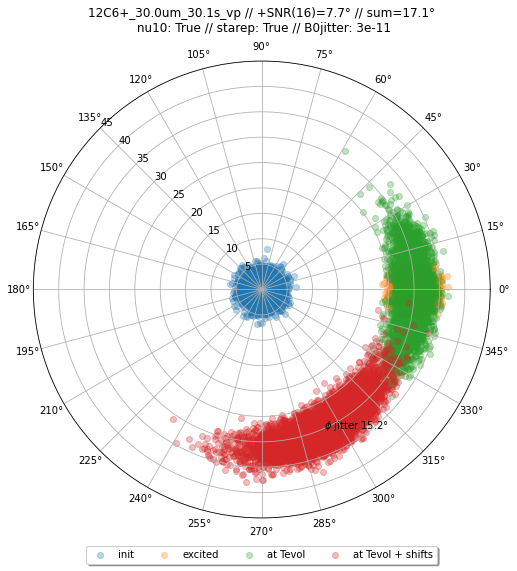

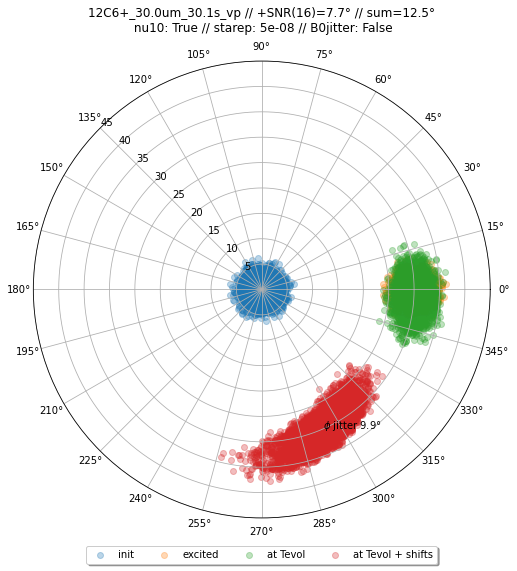

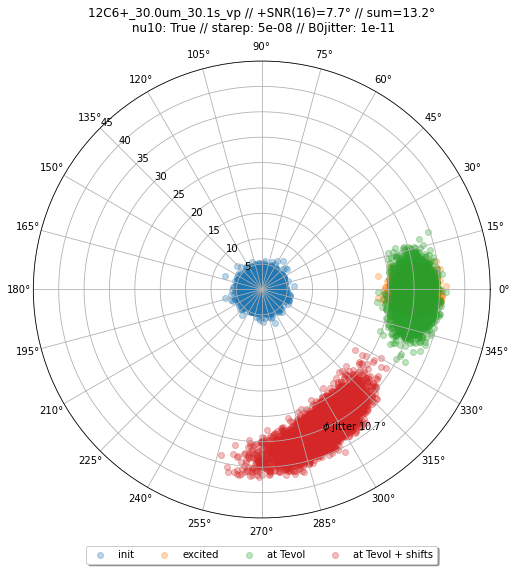

(0.1869612862848488,
 10.712092636458959,
 {'phip0': 0.11301862186751546,
  'phip': 0.1869612862848488,
  'phipSNR': 0.3301652311606163,
  'phim0': 1.8070322223207864,
  'phim': 1.811383196366641,
  'phiz0': 1.8070322223207864,
  'phiz': 1.811383196366641,
  'SNR': 7.713816135258506,
  'vp_jitter': 0.0013191290923588415,
  'vp_precision': 4.2962418720296973e-11,
  'vm_jitter': 0.0095847047571207,
  'vm_precision': 1.2011861936788177e-06,
  'vz_jitter': 0.019940881214513092,
  'vz_precision': 2.84869724836112e-08,
  'vc_jitter': 0.001136893792314914,
  'vc_precision': 3.701761816801837e-11,
  'vpSNR_jitter': 0.0017457617417597677,
  'vpSNR_precision': 5.6857321555658127e-11,
  'vcSNR_jitter': 0.0016993512500786043,
  'vcSNR_precision': 5.533140929278503e-11,
  'results_p': (array([-0.2161791 , -0.22265454,  0.17972545, ..., -0.17775842,
          -0.03745481,  0.04867724]),
   array([-1.28020974, -0.99251386, -1.11015149, ..., -1.53109761,
          -1.08697435, -0.88330194]),
   array(

In [13]:
# lets test :)
tevol = 30.1
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True, magfieldstability=3e-11, sumplot=False)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=5e-8, magfieldstability=False, sumplot=False)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=5e-8, magfieldstability=1e-11, sumplot=False)


 C4 -38184.00000001354 
 C6 -91499999999.9967 
 Tevol 100
mass, charge 12 6
Tevol mean/std 100.00000000000031 1.0764669482019907e-10
frequencies: 
 nu_c: 3.07e+07 
 nu_p: 3.07e+07 
 nu_z: 7.00e+05 
 nu_m: 7.98e+03
freq stds: 
 nu_c: 0.00e+00 
 nu_p: 0.00e+00 
 nu_z: 0.00e+00 
 nu_m: 0.00e+00


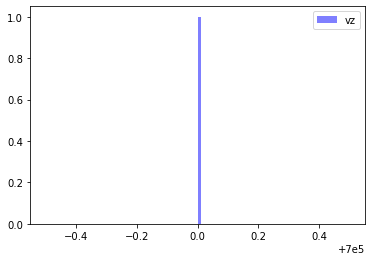

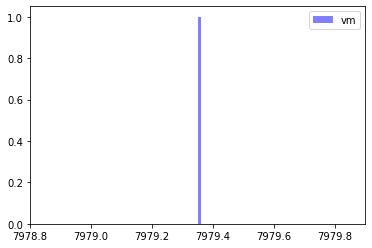

Tp= 219.31611248064584
mean/std thermal rho_p 2.5346635827459373e-06 1.304701180719541e-06
Tm= 0.05699535642235342
mean/std thermal rho_m 2.488103466216216e-06 1.2974965305095612e-06
mean/std thermal z 1.6616397073152128e-05 0.0


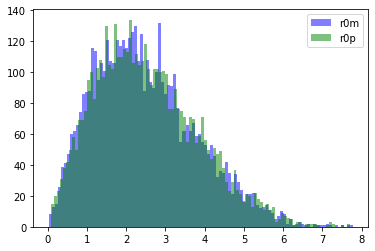

mean/std r0p_exc 3.00429655390293e-05 2.004126785438354e-06
mean/std r0m_exc 2.488103466216216e-06 1.2974965305095612e-06
mean/std z0r_exc 1.6616397073152128e-05 5.093478935328241e-22
axial frequency shift c4  (mean/std): -0.0020808213557756416 0.0003239565085729717
axial frequency shift c6  (mean/std): 4.643277757727041e-06 1.9486304432784713e-06
axial frequency shift b2  (mean/std): 0.009159845438606842 0.0012175467150284931
axial frequency shift rel (mean/std): -6.570811806894853e-05 8.733047577146601e-06
axial frequency shift sum (mean/std): 0.007017959242519978 0.0008876713640787443


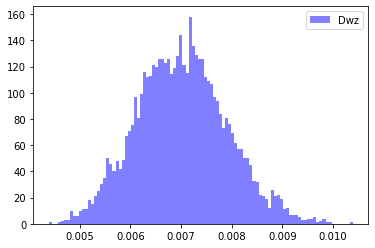

cyclo frequency shift c4  (mean/std): 1.131050494235339e-05 3.7201873651632798e-06
cyclo frequency shift c6  (mean/std): 3.840253960327043e-08 3.51884072751217e-09
cyclo frequency shift b2  (mean/std): -0.00014708005702875735 2.785047264127797e-05
cyclo frequency shift rel (mean/std): -0.005765609876861528 0.0007663183669619268
cyclo frequency shift sum (mean/std): -0.005901341026408329 0.0007904252436076443
magne frequency shift c4  (mean/std): -3.8773438001548194e-05 7.372389835345584e-06
magne frequency shift c6  (mean/std): -5.608259846485724e-12 6.6193460376510515e-12
magne frequency shift b2  (mean/std): 0.00020891949738417024 2.7772234607621942e-05
magne frequency shift sum (mean/std): 0.00017014683252054792 2.0405131451634922e-05
evolved phase std phi0 4.040701194400012
evolved phase std phi without PnA 28.791568962682486
evolved phase std phi  29.03709261626308
phase jitter (phi0, uncorr) [°]: 4.040701194400012
phase jitter (only freq)    [°]: 28.4553087698752
phase jitter (ph

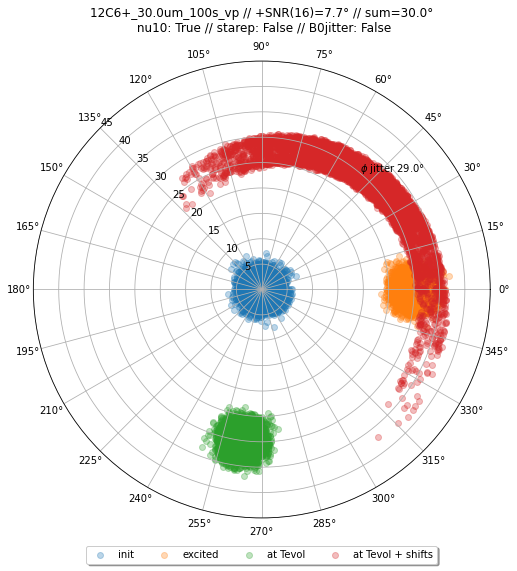

evolved phase std phi0 103.80010833370515
evolved phase std phi without PnA 103.70244498022359
evolved phase std phi  103.64634229830708
evolved phase std phi0 103.93322350539077
evolved phase std phi without PnA 103.39988607138423
evolved phase std phi  103.39988607138423


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:327: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:337: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


<Figure size 432x288 with 0 Axes>

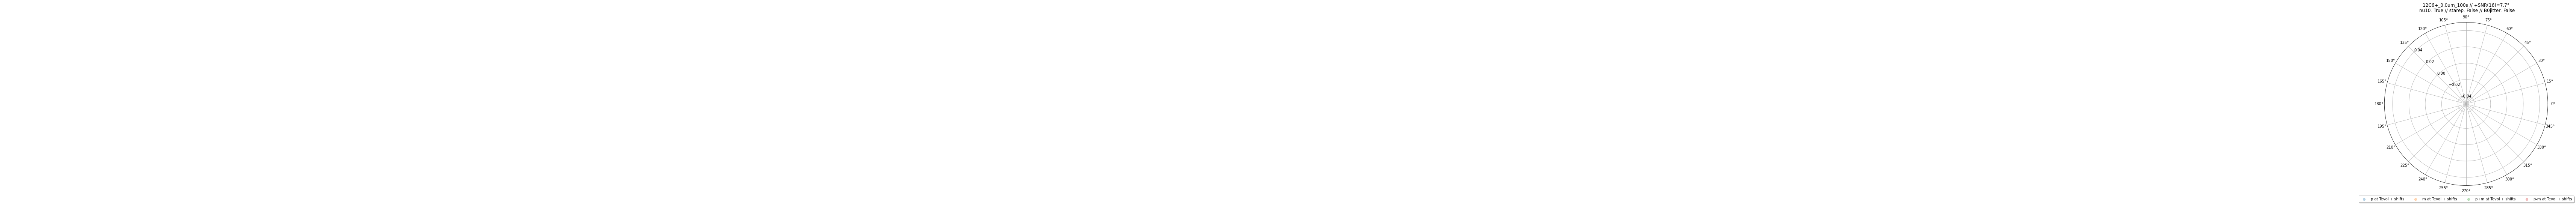

TypeError: object of type 'numpy.float64' has no len()

In [14]:
# lets test :)
tevol = 100
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=5, Tp=Tp, TR=TR_set, verbose=True, show=True, simcount=5e3, starepstability=False, sumplot=True)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=7, Tp=Tp, TR=TR_set, verbose=True, show=True, simcount=5e3, starepstability=False, sumplot=True)


In [ ]:
# lets test :)
tevol = 20
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=5, Tp=Tp, TR=TR_set, verbose=True, show=True, simcount=5e3, starepstability=False, sumplot=True)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=7, Tp=Tp, TR=TR_set, verbose=True, show=True, simcount=5e3, starepstability=False, sumplot=True)


In [ ]:
# lets test :)
tevol = 20
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=exc_radius, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True, sumplot=True, theta=0.0001, thetastability=1e-5)


In [ ]:
# lets test :)
tevol = 50
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2*20, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=False)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=0, excradius_m=exc_radius, SNR=SNR, B2=B2*20, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=False)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True,magfieldstability=False)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True,magfieldstability=3e-11)


In [ ]:
# lets test :)
tevol = 100
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=False,magfieldstability=False)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_m=exc_radius, excradius_p=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=False,magfieldstability=False)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=False,magfieldstability=2e-11)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_m=exc_radius, excradius_p=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=False,magfieldstability=2e-11)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_p=exc_radius, excradius_m=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True,magfieldstability=False)
delphi(ion=ion, B0=B0, evol_time=tevol, excradius_m=exc_radius, excradius_p=0, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True,magfieldstability=False)


In [ ]:
# lets test :)
delphi(ion=ion, B0=B0, evol_time=3.0001, excradius_z=50e-6, excradius_p=20e-6, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True)
delphi(ion=ion, B0=B0, evol_time=100.0001, excradius_z=0, excradius_p=20e-6, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True)
delphi(ion=ion, B0=B0, evol_time=100.0001, excradius_z=10e-6, excradius_p=20e-6, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True)
delphi(ion=ion, B0=B0, evol_time=100.0001, excradius_m=50e-6, excradius_p=20e-6, SNR=SNR, B2=B2, Tz=Tz, Tp=Tp, TR=TR_set, verbose=False, show=True, simcount=5e3, starepstability=True)


In [ ]:
# lets test :)
#delphi(ion=ion, evol_time=0.1, excradius_p=exc_radius, SNR=SNR, Tz=Tz, verbose=False, show=True, simcount=5e2, starepstability=False, nu10stability=False)
#delphi(ion=ion, evol_time=0.1, excradius_p=exc_radius, SNR=SNR, Tz=Tz, verbose=False, show=True, simcount=5e2, starepstability=False)
#delphi(ion=ion, evol_time=40, excradius_p=exc_radius, SNR=SNR, Tz=Tz, verbose=False, show=True, simcount=5e2, starepstability=False, nu10stability=False)
delphi(ion=ion, evol_time=40, excradius_p=exc_radius, SNR=SNR, Tz=Tz, verbose=False, show=True, simcount=5e2, starepstability=False)
delphi(ion=ion, evol_time=40, excradius_p=exc_radius, SNR=SNR, Tz=Tz, verbose=False, show=True, simcount=5e2, starepstability=True)
delphi(ion=ion, evol_time=40, excradius_m=0, excradius_p=exc_radius, SNR=SNR, B2=B2, Tz=Tz, TR=TR_set, verbose=True, show=True, simcount=5e2, starepstability=True)
delphi(ion=ion, evol_time=40, excradius_m=exc_radius, excradius_p=0, SNR=SNR, B2=B2, Tz=Tz, TR=TR_set, verbose=True, show=True, simcount=5e2, starepstability=True)
delphi(ion=ion, evol_time=40, excradius_m=exc_radius, excradius_p=exc_radius, SNR=SNR, B2=B2, Tz=Tz, TR=TR_set, verbose=True, show=True, simcount=5e2, starepstability=True)
delphi(ion=ion, evol_time=40, excradius_z=exc_radius, excradius_p=exc_radius, SNR=SNR, B2=B2, Tz=Tz, TR=TR_set, verbose=True, show=True, simcount=5e2, starepstability=True)
#delphi(ion=ion, evol_time=20, excradius_m=0, excradius_p=exc_radius, SNR=SNR, B2=B2, Tz=Tz, TR=TR_set,  verbose=True, show=True, simcount=5e2, starepstability=False)
#delphi(ion=ion, evol_time=20, excradius_m=exc_radius, excradius_p=0, SNR=SNR, B2=B2, Tz=Tz, TR=TR_set,  verbose=True, show=True, simcount=5e2, starepstability=False)



#delphi(ion='172Yb42+', evol_time=40.1, excradius_p=20e-6, SNR=16, show=True,
#        nu10stability=False, starepstability=False, simcount=1e3)
#delphi(ion='172Yb42+', evol_time=40.1, excradius_p=20e-6, SNR=16, show=True,
#        nu10stability=True, starepstability=False, simcount=1e3)
#delphi(ion='172Yb42+', evol_time=40.1, excradius_p=20e-6, SNR=16, show=True,
#        nu10stability=True, starepstability=True, simcount=1e3)
#delphi(ion='187Re29+', evol_time=40, excradius_p=20e-6, show=True)
#delphi(ion='187Re29+', evol_time=60, excradius_p=20e-6, show=False)
#delphi(ion='172Yb45+', evol_time=0.1, excradius_p=40e-6, show=False)
#delphi(ion='172Yb45+', evol_time=40.1, excradius_p=40e-6, show=False)
#delphi(ion='172Yb45+', evol_time=70.1, excradius_p=40e-6, show=False)

In [ ]:
exc_amp = 50e-6
strp = True
sc = 5e3
B22 = B2
TR_here = 0.88
SNRh = 16
delphi(ion=ion, evol_time=0.1, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=8, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=strp)
delphi(ion=ion, evol_time=0.1, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=2, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=strp)
delphi(ion=ion, evol_time=20, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=8, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=strp)
delphi(ion=ion, evol_time=20, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=2, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=strp)
delphi(ion=ion, evol_time=40, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=8, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=strp)
delphi(ion=ion, evol_time=40, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=2, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=strp)
delphi(ion=ion, evol_time=70, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=8, TR=TR_here, verbose=True, show=True, simcount=sc, starepstability=strp)
delphi(ion=ion, evol_time=70, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=2, TR=TR_here, verbose=True, show=True, simcount=sc, starepstability=strp)


In [ ]:
exc_amp = 20e-6
strp = True
sc = 5e3
B22 = B2
TR_here = 0.88
SNRh = 10
Tevol = 0.1 
delphi(ion="12C3+",    evol_time=Tevol, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=8, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=True)
delphi(ion="172Yb43+", evol_time=Tevol, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=8, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=True)
delphi(ion="12C3+",    evol_time=Tevol, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=2, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=True)
delphi(ion="172Yb43+", evol_time=Tevol, excradius_m=0, excradius_p=exc_amp, SNR=SNRh, B2=B22, Tz=2, TR=TR_here, verbose=False, show=True, simcount=sc, starepstability=True)


 ## Scanning some settings

In [128]:
### phase jitter vs. evolution time for different excitation radii
simcount = 1e3
exc_radius = 20e-6
tevol = 100
SNR = 15
TR_set = 0.880143


# Temperature & excitation radii

In [204]:
### phase jitter vs. evolution time for different excitation radii
simcount = 5e3
Tspan = np.arange(1, 20, 2)
exc_radii = np.arange(8, 74, 1)
T_evol = 0.1
ion= "12C6+"
SNR = 25
B2 = 0.06
TR = 0.8801
exc_radius = 20e-6

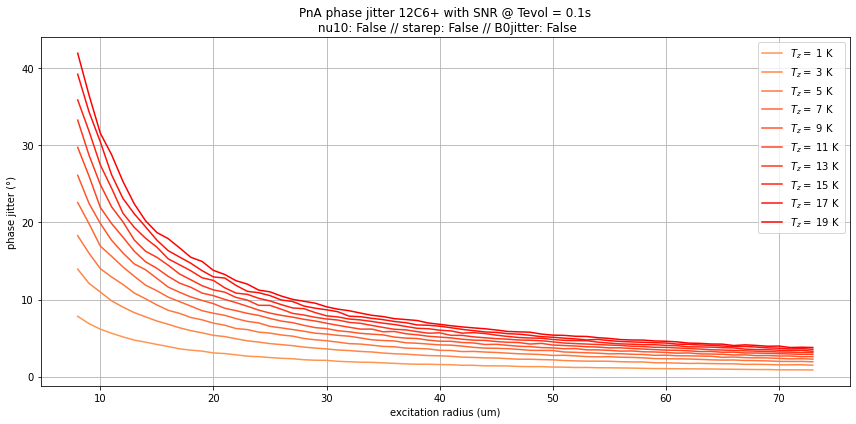

In [205]:
magfieldstability = False #1e-11
nu10stability = False
starepstability = False#5e-7

plt.figure(figsize=(12,6))
dphis = []
for i, Tz in enumerate(Tspan):
    for e in exc_radii:
        dphi, dphid, data = delphi(ion=ion, evol_time=T_evol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        #dphid = data["phipSNR"]*180/np.pi
        phid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(exc_radii, dphis, label=r'$T_{z} =$ '+str(Tz)+' K', c=color[i])
    dphis=[]
    print("", end="\r ")

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' with SNR @ Tevol = ' + str(T_evol) + 's' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



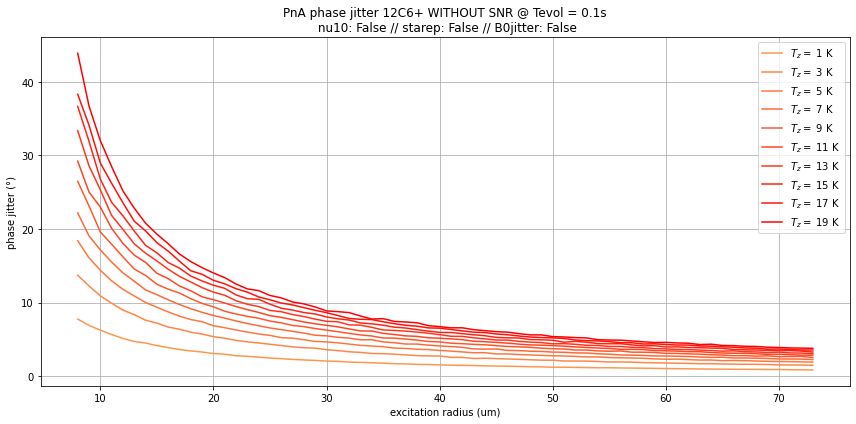

In [206]:
magfieldstability = False #1e-11
nu10stability = False
starepstability = False#5e-7

plt.figure(figsize=(12,6))
dphis = []
for i, Tz in enumerate(Tspan):
    for e in exc_radii:
        dphi, dphid, data = delphi(ion=ion, evol_time=T_evol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        #dphid = data["phipSNR"]*180/np.pi
        phid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(exc_radii, dphis, label=r'$T_{z} =$ '+str(Tz)+' K', c=color[i])
    dphis=[]
    print("", end="\r ")

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' WITHOUT SNR @ Tevol = ' + str(T_evol) + 's' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [207]:
### phase jitter vs. evolution time for different excitation radii
simcount = 5e3
Tspan = np.arange(1, 20, 2)
exc_radii = np.arange(8, 74, 1)
T_evol = 20
ion= "12C6+"
SNR = 25
B2 = 0.06
TR = 0.8801
exc_radius = 20e-6

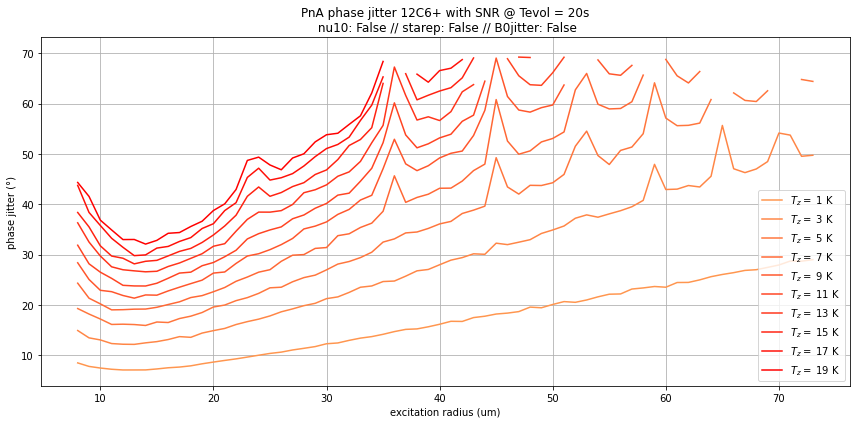

In [208]:
magfieldstability = False #1e-11
nu10stability = False
starepstability = False#5e-7

plt.figure(figsize=(12,6))
dphis = []
for i, Tz in enumerate(Tspan):
    for e in exc_radii:
        dphi, dphid, data = delphi(ion=ion, evol_time=T_evol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        #dphid = data["phipSNR"]*180/np.pi
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(exc_radii, dphis, label=r'$T_{z} =$ '+str(Tz)+' K', c=color[i])
    dphis=[]
    print("", end="\r ")

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' with SNR @ Tevol = ' + str(T_evol) + 's' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [209]:
### phase jitter vs. evolution time for different excitation radii
simcount = 5e3
Tspan = np.arange(1, 20, 2)
T_evol = np.arange(1, 40, 1)
ion= "12C6+"
SNR = 25
B2 = 0.06
TR = 0.8801
exc_radius = 15e-6

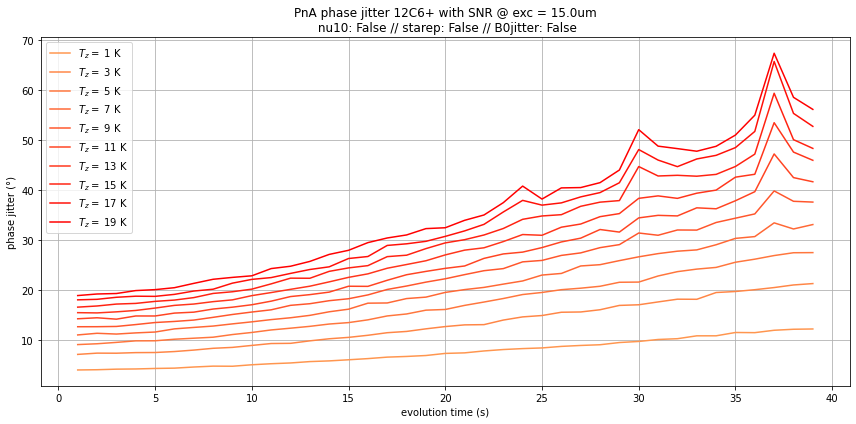

In [210]:
magfieldstability = False #1e-11
nu10stability = False
starepstability = False#5e-7

plt.figure(figsize=(12,6))
dphis = []
for i, Tz in enumerate(Tspan):
    for tevol in T_evol:
        dphi, dphid, data = delphi(ion=ion, evol_time=tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        #dphid = data["phipSNR"]*180/np.pi
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(T_evol, dphis, label=r'$T_{z} =$ '+str(Tz)+' K', c=color[i])
    dphis=[]
    print("", end="\r ")

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' with SNR @ exc = ' + str(exc_radius*1e6) + 'um' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



# Accumulation time & excitation radii

In [211]:
### phase jitter vs. evolution time for different excitation radii
simcount = 5e3
tspan = np.arange(0.1, 20, 1)
exc_radii = np.arange(8, 40, 5)
ion= "12C6+"
SNR = 25
Tz = 5
B2 = 0.06
TR = 0.8801
exc_radius = 20e-6

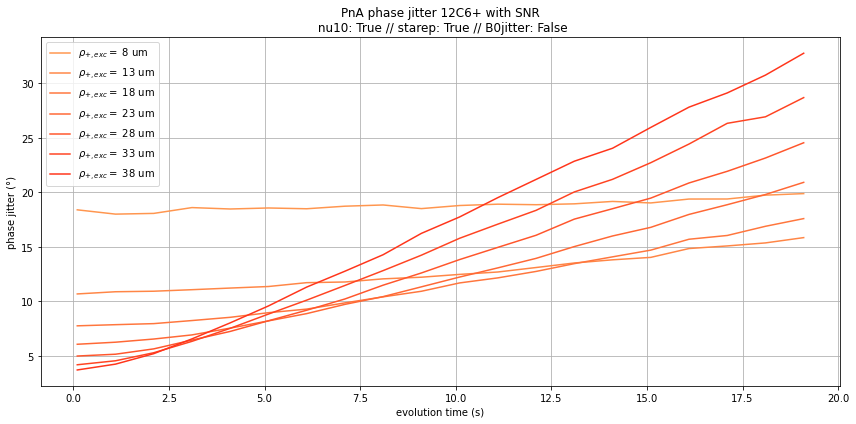

In [212]:
magfieldstability = False #1e-11
nu10stability = True
starepstability = True#5e-7
Tz = 5

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        SNRhere = 20
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNRhere, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount*2, show=False, verbose=False)
        #dphid = data["phipSNR"]*180/np.pi
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' with SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



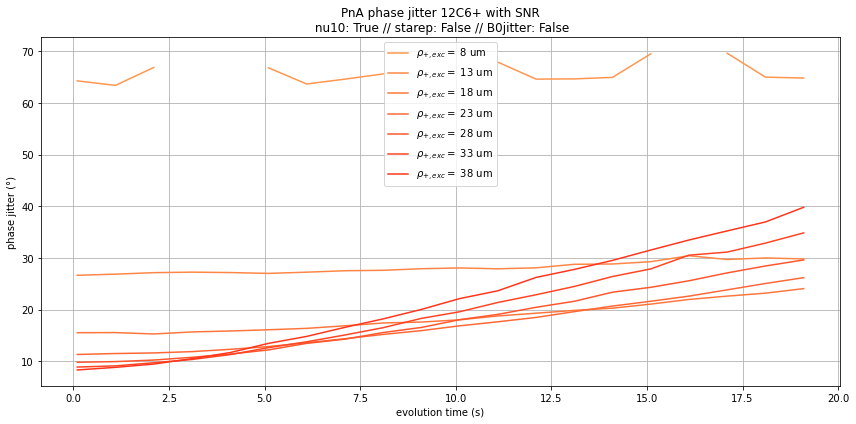

In [213]:
magfieldstability = False #1e-11
nu10stability = True
starepstability = False
Tz = 7

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        SNRhere = e
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNRhere, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount*2, show=False, verbose=False)
        dphid = data["phipSNR"]*180/np.pi
        #dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' with SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False #1e-11
nu10stability = True
starepstability = False
Tz = 7

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=20, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount*2, show=False, verbose=False)
        #dphid = data["phipSNR"]*180/np.pi
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i*2])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' with SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



# B2 scan, cyclotron / magnetron

In [ ]:

Tz_range = [1,4,8,12,15]
B2_range = np.logspace(-4, 1, 50)
B2_range2 = [10e-2, 50e-2, 100e-2]
SNR=16
exc_radius=20e-6
tevol = 20

In [ ]:
magfieldstability = False
nu10stability = False
starepstability = False

plt.figure(figsize=(12,6))
dphis = []
for i, T in enumerate(Tz_range):
    for B in B2_range:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tevol, SNR=SNR, Tz=T, B2=B, TR=TR_set, 
                                excradius_p=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)
    
    
    plt.plot(B2_range, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[i])
    dphis=[]
    
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('B2 (uT/mm2)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol='+str(tevol) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:

plt.figure(figsize=(12,6))
dphis = []
for i, T in enumerate(Tz_range):
    for B in B2_range:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tevol, SNR=SNR, Tz=T, B2=B, TR=TR_set, 
                                excradius_m=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data['phim']*180/np.pi
        #if dphid > 100: dphid = None
        dphis.append(dphid)
    plt.plot(B2_range, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[i])
    dphis=[]

ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('B2 (uT/mm2)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' magnetron // Tevol='+str(tevol) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



# TR scan

In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

Tz_range = [1, 2, 4, 6, 8, 10]
tr_range = np.arange(0, 0.002, 0.0001) + TR_set - 0.001

plt.figure(figsize=(12,6))
dphis = []
for idx, T in enumerate(Tz_range):
    for tr in tr_range:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tevol, SNR=SNR, Tz=T, B2=B2, TR=tr, 
                                excradius_p=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 5e3, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(tr_range, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('TR (1)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol='+str(tevol) +' // rho+='+str(exc_radius) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

Tz_range = [1, 2, 4, 6, 8, 10]
tr_range = np.arange(0, 0.041, 0.001) + TR_set

plt.figure(figsize=(12,6))
dphis = []
for idx, T in enumerate(Tz_range):
    for tr in tr_range:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tevol, SNR=SNR, Tz=T, B2=B2, TR=tr, 
                                excradius_p=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 5e3, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(tr_range, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('TR (1)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol='+str(tevol) +' // rho+='+str(exc_radius) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

exc_range = [10, 20, 30, 40, 50, 100]
tr_range = np.arange(0, 0.041, 0.001) + TR_set
print(B2, Tz, exc_radius)
plt.figure(figsize=(12,6))
dphis = []
for idx, exc in enumerate(exc_range):
    for tr in tr_range:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tevol/2, SNR=SNR, Tz=Tz, B2=B2, TR=tr, 
                                excradius_p=exc*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 5e3, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        #dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(tr_range, dphis, label=r'$\rho_p \,= $ '+str(exc)+' um', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('TR (1)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol='+str(tevol) +' // rho+='+str(exc_radius) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

tevol_range = np.arange(1, 100, 2) # [1, 2, 4, 6, 8, 10]
tr_range = np.arange(0, 5e-3, 0.001) + TR_set

plt.figure(figsize=(12,6))
for idx, tr in enumerate(tr_range):
    dphis=[]
    for idx2, tevol2 in enumerate(tevol_range):
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tevol2, SNR=SNR, Tz=6, B2=B2, TR=tr, 
                                excradius_p=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 10e3, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(tevol_range, dphis, label=r'$TR \,= $ '+str(tr), c=color[idx])
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol='+str(tevol) +' // rho+='+str(exc_radius) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

tevol_range = np.arange(1, 100, 2) # [1, 2, 4, 6, 8, 10]
tr_range = np.arange(0, 5e-3, 0.001) + TR_set

plt.figure(figsize=(12,6))
for idx, tr in enumerate(tr_range):
    dphis=[]
    for idx2, tevol2 in enumerate(tevol_range):
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tevol2, SNR=SNR, Tz=6, B2=B2, TR=tr, 
                                excradius_m=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 10e3, show=False, verbose=False)
        dphid = data['phim']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(tevol_range, dphis, label=r'$TR \,= $ '+str(tr), c=color[idx])
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol='+str(tevol) +' // rho+='+str(exc_radius) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



# temperature

In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

Tz_range = [1, 2, 4, 6, 8]
espan = np.arange(10, 80, 5)
Tevolhere = 0.1
SNRhere = 18

plt.figure(figsize=(12,6))
dphis = []
for idx, T in enumerate(Tz_range):
    for e in espan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevolhere, SNR=SNRhere, Tz=T, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 1e4, show=False, verbose=False)
        #dphid = data['phip']*180/np.pi
        dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(espan, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol ='+str(Tevolhere) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = True

Tz_range = [1, 2, 4, 6, 8]
tspan = np.arange(1, 20, 2)
SNRhere = 30

plt.figure(figsize=(12,6))
dphis = []
for idx, T in enumerate(Tz_range):
    for tacc in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tacc, SNR=SNRhere, Tz=T, B2=B2, TR=TR_set, 
                                excradius_p=20e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 1e4, show=False, verbose=False)
        #dphid = data['phip']*180/np.pi
        dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(tspan, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('T evolution (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol ='+str(Tevolhere) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 2e-11
nu10stability = True
starepstability = True

Tz_range = [ 5.5]
espan = np.arange(10, 80, 5)
Tevolhere = 60.1

plt.figure(figsize=(12,6))
dphis = []
for idx, T in enumerate(Tz_range):
    for e in espan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevolhere, SNR=SNR, Tz=T, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, excradius_m=100e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 1e4, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        #dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(espan, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol ='+str(Tevolhere) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

Tz_range = [1, 2, 4, 6, 8, 10]
tspan = np.arange(1, 80, 5)

plt.figure(figsize=(12,6))
dphis = []
for idx, T in enumerate(Tz_range):
    for tacc in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tacc, SNR=SNR, Tz=T, B2=B2, TR=TR_set, 
                                excradius_p=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 1e4, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        #dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(tspan, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('T evolution (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // rho+='+str(exc_radius) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = True

Tz_range = [1, 2, 4, 6, 8, 10]
tspan = np.arange(1, 100, 5)

plt.figure(figsize=(12,6))
dphis = []
for idx, T in enumerate(Tz_range):
    for tacc in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=tacc, SNR=SNR, Tz=T, B2=B2, TR=TR_set, 
                                excradius_p=exc_radius, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 1e4, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        #dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(tspan, dphis, label=r'$T_z \,= $ '+str(T)+' K', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('T evolution (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // rho+='+str(exc_radius) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

e_range = [10, 20, 30, 40, 50]
Tzspan = np.arange(0.1, 15, 0.5)
Tevol = 40.1

plt.figure(figsize=(12,6))
dphis = []
for idx, e in enumerate(e_range):
    for T in Tzspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=T, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 1e4, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        #dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(Tzspan, dphis, label=r'$rho+ \,= $ '+str(e)+' um', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('Temp (K)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol='+str(Tevol) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = True

e_range = [10, 20, 30, 40, 50]
Tzspan = np.arange(0.1, 15, 0.5)
Tevol = 40.1

plt.figure(figsize=(12,6))
dphis = []
for idx, e in enumerate(e_range):
    for T in Tzspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=T, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 1e4, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        #dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
    
    
    plt.plot(Tzspan, dphis, label=r'$rho+ \,= $ '+str(e)+' um', c=color[idx])
    dphis=[]
    
#ax = plt.gca()
#ax.set_xscale('log')
plt.xlabel('Temp (K)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' cyclotron // Tevol='+str(Tevol) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



# magnetic field drifts

In [ ]:
magfieldstability = False
nu10stability = False
starepstability = False

drifts = [1e-10, 5e-10, 1e-9, 5e-9, 1e-8]
tspan = np.arange(0.1, 40, 1)

plt.figure(figsize=(12,6))
dphis = []
for i, drift in enumerate(drifts):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=exc_radius, magfieldstability=magfieldstability, 
                                bdrift_per_second=float(1/3600)*drift,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        end = datetime.now()
        seconds = (end-start).total_seconds()
        dphid = data['phip']*180/np.pi
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'magfield drift '+str(drift)+' dB/B per hour', c=color[i*2])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = False
starepstability = False

drifts = [1e-10, 5e-10, 1e-9, 5e-9, 1e-8]
tspan = np.arange(0.1, 40, 1)

plt.figure(figsize=(12,6))
dphis = []
for i, drift in enumerate(drifts):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_m=exc_radius, magfieldstability=magfieldstability, 
                                bdrift_per_second=float(1/3600)*drift,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 10, show=False, verbose=False)
        end = datetime.now()
        seconds = (end-start).total_seconds()
        dphid = data['phim']*180/np.pi
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'magfield drift '+str(drift)+' dB/B per hour', c=color[i*2])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



# excitation radii

In [ ]:
### phase jitter vs. evolution time for different excitation radii
simcount = 5e3
ion = "12C6+"
#ion = "20Ne10+"
tspan = np.arange(0.1, 20, 1)
#####exc_radii = np.asarray([9.5, 15, 16, 20])#*1.3
exc_radii = np.asarray([17, 24.7, 26.8, 34])*0.6           # trap3 carbon @4 K  -> good
exc_radii = np.asarray([17, 24.7, 28.9])*0.5               # trap3 neon   @10 K -> not good
exc_radii = np.asarray([15, 18.8*1.1, 22.5*1.1**2, 30.0*1.1**3])*0.6         # trap2 carbon @4 K  -> not good
#exc_radii = np.asarray([11.3, 15.0, 18.8, 20.6, 45])*0.5   # trap2 neon   @4 K  -> ok ish
print(exc_radii)

SNR = 16
Tz = 4
B2 = 0.06
TR_set = 0.8801
exc_radius = 20e-6

In [ ]:
magfieldstability = False
nu10stability = False
starepstability = False

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=30, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount*5, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i*2])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()


In [ ]:
magfieldstability = False
nu10stability = False
starepstability = False

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set-0.001, 
                                excradius_m=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data['phim']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('Magnetron PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = False
starepstability = False

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_m=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data['phim']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False
nu10stability = True
starepstability = False

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data['phip']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()


In [ ]:
magfieldstability = False
nu10stability = True
starepstability = True

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphis.append(data["phip"]*180/np.pi)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 2e-11
nu10stability = True
starepstability = False

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 2e-11
nu10stability = True
starepstability = True
# SNR!

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=20, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data["phipSNR"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 2e-11
nu10stability = True
starepstability = True
thetastability = 1e-5
# Theta angle!

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                theta = 0.0005, thetastability=thetastability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 2e-11
nu10stability = True
starepstability = True
# MAGNETRON

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_m=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data["phim"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter MAGNETRON ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 2e-11
nu10stability = True
starepstability = True
# HIGHER B2

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2*50, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter HIGH B2 ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 2e-11
nu10stability = True
starepstability = True
# AXIALLY EXCITED

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, excradius_m=80*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i*2])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter HIGH B2 ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 2e-11
nu10stability = True
starepstability = True
# AXIALLY EXCITED

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, excradius_z=80*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data["phip"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i*2])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter HIGH B2 ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = False #1e-11
nu10stability = True
starepstability = False

plt.figure(figsize=(12,6))
dphis = []
for i, e in enumerate(exc_radii):
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=20, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        dphid = data["phipSNR"]*180/np.pi
        if dphid > 70: dphid = None
        dphis.append(dphid)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um', c=color[i*2])
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + ' with SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()



In [ ]:
magfieldstability = 3e-11
nu10stability = True
starepstability = True

plt.figure(figsize=(12,6))
dphis = []
for e in exc_radii:
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=10, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = simcount, show=False, verbose=False)
        end = datetime.now()
        seconds = (end-start).total_seconds()
        #print("excecution time", seconds)
        #prec = data['vp_precision']
        prec = data['vpSNR_precision']
        dphis.append(prec)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um')
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('frequency vp precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.ylim((1e-11, 1e-9))
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()

In [ ]:
magfieldstability = 3e-11
nu10stability = True
starepstability = True

plt.figure(figsize=(12,6))
dphis = []
for e in exc_radii:
    for t in tspan:
        start = datetime.now()
        dphi, dphid, data = delphi(ion=ion, evol_time=t, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability = nu10stability, starepstability=starepstability,
                                simcount = 1e3, show=False, verbose=False)
        end = datetime.now()
        seconds = (end-start).total_seconds()
        #print("excecution time", seconds)
        prec = data['vc_precision']
        dphis.append(prec)

    plt.plot(tspan, dphis, label=r'$\rho_{+,exc} =$ '+str(e)+' um')
    dphis=[]

plt.xlabel('evolution time (s)')
plt.ylabel('frequency vc precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) + ' w/o SNR' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.ylim((7e-12, 5e-10))
plt.grid(which='both')
plt.tight_layout()
name = ion + '_'+str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_Tevol_exc.png', dpi=100)
plt.show()

In [ ]:
# phase jitter vs excitation radius for different evolution times
ion = '172Yb42+'
ion = '12C3+'
#ion = '1H1+'
simcount = 1e3
Tevols = [0.1, 1, 5, 20]
#Tevols = [0.1, 1, 20, 40, 60, 80]
#Tevols = [0.1, 5, 10, 20]
espan = np.arange(10, 40, 0.5)
SNR = 20
Tz = 4
B2 = 6e-2
TR_set = 0.880143 # C4opt = 0.880143, 0.88

In [ ]:
nu10stability=False
starepstability=False
magfieldstability = False


plt.figure(figsize=(12,6))

dphis = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phip']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)
        
    plt.plot(espan, dphis, label='Tevol '+str(Tevol))
    dphis = []

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability= 2e-7
magfieldstability = 3e-11


plt.figure(figsize=(12,6))

dphis = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_m=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phim']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)
        
    plt.plot(espan, dphis, label='Tevol '+str(Tevol))
    dphis = []

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter magnetron(°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability= 2e-7
magfieldstability = 3e-11


plt.figure(figsize=(12,6))

dphis = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_m=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phim']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)
        
    plt.plot(espan, dphis, label='Tevol '+str(Tevol))
    dphis = []

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter magnetron(°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = 3e-11

plt.figure(figsize=(12,6))
dphis = []
dphisSTA = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phip']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)

    #    dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
    #                    excradius_p=e*1e-6, magfieldstability=magfieldstability,
    #                    nu10stability=nu10stability, starepstability=True,
    #                    show=False, verbose=False, simcount=simcount)
    #    dphid = data['phip']*180/np.pi
    #    if dphid > 50: dphid = None
    #    dphisSTA.append(dphid)

    plt.plot(espan, dphis, label='Tevol '+str(Tevol))
    #plt.plot(espan, dphis, "g--", label='Tevol '+str(Tevol))
    #plt.plot(espan, dphisSTA, "b-", label='Tevol '+str(Tevol)+'_starep')
    dphis = []
    #dphisSTA = []

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=False
starepstability=False
magfieldstability = False

plt.figure(figsize=(12,6))
dphis = []
dphisSTA = []
for Tevol in Tevols:
    for e in espan:
        eSNR = 20*np.log10(e / 10)
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=eSNR, Tz=Tz, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phipSNR']*180/np.pi
        if dphid > 50: dphid = None
        dphis.append(dphid)

    #    dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
    #                    excradius_p=e*1e-6, magfieldstability=magfieldstability,
    #                    nu10stability=nu10stability, starepstability=True,
    #                    show=False, verbose=False, simcount=simcount)
    #    dphid = data['phip']*180/np.pi
    #    if dphid > 50: dphid = None
    #    dphisSTA.append(dphid)

    plt.plot(espan, dphis, label='Tevol '+str(Tevol))
    #plt.plot(espan, dphis, "g--", label='Tevol '+str(Tevol))
    #plt.plot(espan, dphisSTA, "b-", label='Tevol '+str(Tevol)+'_starep')
    dphis = []
    #dphisSTA = []

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) + '!!! PnP and SNR included !!!' +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=False
starepstability=True
magfieldstability = 3e-11

plt.figure(figsize=(12,6))
dphis = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phip']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)
        
    plt.plot(espan, dphis, label='Tevol '+str(Tevol))
    dphis = []

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = 3e-11

plt.figure(figsize=(12,6))
dphis = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phip']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)
        
    plt.plot(espan, dphis, label='Tevol '+str(Tevol))
    dphis = []

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = 2e-11

plt.figure(figsize=(12,6))
dphis = []
for i, Tevol in enumerate(Tevols):
    for e in espan:
        eSNR = 20*np.log10(e / 10)
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=eSNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phipSNR']*180/np.pi
        if dphid > 100: dphid = None
        dphis.append(dphid)
        
    plt.plot(espan, dphis, label='Tevol '+str(Tevol), c=color[i])
    dphis = []

plt.xlabel('excitation radius (um)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = False

Tspan = np.arange(1, 150, 1)
exc_list = [5, 10, 20, 30]

plt.figure(figsize=(12,6))

dphis = []
for i, e in enumerate(exc_list):
    for Tevol in Tspan:
        eSNR = 20*np.log10(e / 10)
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=eSNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phip']*180/np.pi
        #dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
        
    plt.plot(Tspan, dphis, label='exc rad '+str(e)+' [um]', c=color[i*2])
    dphis = []

plt.xlabel('PAT (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = 3e-11

Tspan = np.arange(1, 150, 1)
exc_list = [2.5, 5, 10, 20, 30]

plt.figure(figsize=(12,6))

dphis = []
for i, e in enumerate(exc_list):
    for Tevol in Tspan:
        eSNR = 20*np.log10(e / 10)
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=eSNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        dphid = data['phip']*180/np.pi
        #dphid = data['phipSNR']*180/np.pi
        dphis.append(dphid)
        
    plt.plot(Tspan, dphis, label='exc rad '+str(e)+' [um]', c=color[i])
    dphis = []

plt.xlabel('PAT (s)')
plt.ylabel('phase jitter (°)')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = False

plt.figure(figsize=(12,6))
vps = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        vp_jitter = data['vp_jitter']
        vps.append(vp_jitter)

    plt.plot(espan, vps, label='Tevol '+str(Tevol))
    vps = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency jitter vp (Hz)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)

plt.show()


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = False

plt.figure(figsize=(12,6))
vps = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        vp_jitter = data['vp_jitter']
        vps.append(vp_jitter)

    plt.plot(espan, vps, label='Tevol '+str(Tevol))
    vps = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency jitter vp (Hz)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)

plt.show()


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = 3e-11

plt.figure(figsize=(12,6))
vps = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_m=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        vp_jitter = data['vm_jitter']
        vps.append(vp_jitter)

    plt.plot(espan, vps, label='Tevol '+str(Tevol))
    vps = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency jitter vm (Hz)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)

plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = False

plt.figure(figsize=(12,6))
vps = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        vp_jitter = data['vp_precision']
        dphid = data['phipSNR']*180/np.pi
        if dphid > 100: vp_jitter = None
        vps.append(vp_jitter)

    plt.plot(espan, vps, label='Tevol '+str(Tevol))
    vps = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vp precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = False

plt.figure(figsize=(12,6))
vps = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        vp_jitter = data['vp_precision']
        dphid = data['phipSNR']*180/np.pi
        if dphid > 100: vp_jitter = None
        vps.append(vp_jitter)

    plt.plot(espan, vps, label='Tevol '+str(Tevol))
    vps = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vp precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = 3e-11

plt.figure(figsize=(12,6))
vps = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        vp_jitter = data['vp_precision']
        dphid = data['phipSNR']*180/np.pi
        if dphid > 100: vp_jitter = None
        vps.append(vp_jitter)

    plt.plot(espan, vps, label='Tevol '+str(Tevol))
    vps = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vp precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = False

plt.figure(figsize=(12,6))
vps = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        vp_jitter = data['vc_jitter']
        vps.append(vp_jitter)

    plt.plot(espan, vps, label='Tevol '+str(Tevol))
    vps = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency jitter vc (Hz)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = False

plt.figure(figsize=(12,6))
precs = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        precision = data['vc_precision']
        precs.append(precision)

    plt.plot(espan, precs, label='Tevol '+str(Tevol))
    precs = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vc precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = False

plt.figure(figsize=(12,6))
precs = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        precision = data['vc_precision']
        precs.append(precision)

    plt.plot(espan, precs, label='Tevol '+str(Tevol))
    precs = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vc precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = 3e-11

plt.figure(figsize=(12,6))
precs = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        precision = data['vc_precision']
        precs.append(precision)

    plt.plot(espan, precs, label='Tevol '+str(Tevol))
    precs = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vc precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = 3e-11

plt.figure(figsize=(12,6))
precs = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tp, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        precision = data['vc_precision']
        precs.append(precision)

    plt.plot(espan, precs, label='Tevol '+str(Tevol))
    precs = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vc precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = False
SNR=22

plt.figure(figsize=(12,6))
precs = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, excradius_m=0, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        precision = data['vcSNR_precision']
        precs.append(precision)

    plt.plot(espan, precs, label='Tevol '+str(Tevol))
    precs = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vc precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.ylim(1e-11, None)
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
nu10stability=True
starepstability=False
magfieldstability = 1e-11
SNR=22

plt.figure(figsize=(12,6))
precs = []
for Tevol in Tevols:
    for e in espan:
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=SNR, Tz=Tz, Tp=Tz, B0=B0, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, excradius_m=0, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        precision = data['vcSNR_precision']
        dphid = data['phipSNR']*180/np.pi
        if dphid > 100: precision = None
        precs.append(precision)

    plt.plot(espan, precs, label='Tevol '+str(Tevol))
    precs = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vc precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.ylim(1e-11, None)
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()


In [ ]:
# this is a poor man attempt of simulating PnP SNR, this is by far not quantitatively usable

snrlist = []
espan = np.arange(5, 100, 0.5)

for e in espan:
    snrlist.append( 20*np.log10(e / 10) )

plt.plot(espan, snrlist)
plt.xlabel('excitation radius (um)')
plt.ylabel('SNR')
plt.grid(which='both')

plt.show()

In [ ]:
# phase jitter vs excitation radius for different evolution times
ion = '172Yb42+'
#ion = '12C6+'
simcount = 1e3
Tevols = [0.1, 20, 40, 60, 80, 100, 120, 150]
Tevols = [0.1, 20, 40, 60, 80, 100]
espan = np.arange(5, 100, 0.5)
#Tevols = [0.1, 5, 10, 20]
Tz = 15


In [ ]:
nu10stability=True
starepstability=True
magfieldstability = 3e-11

plt.figure(figsize=(12,6))
precs = []
for Tevol in Tevols:
    for e in espan:
        eSNR = 20*np.log10(e / 10)*2
        dphi, dphid, data = delphi(ion=ion, evol_time=Tevol, SNR=eSNR, Tz=Tz, B2=B2, TR=TR_set, 
                                excradius_p=e*1e-6, excradius_m=0, magfieldstability=magfieldstability,
                                nu10stability=nu10stability, starepstability=starepstability,
                                show=False, verbose=False, simcount=simcount)
        precision = data['vcSNR_precision']
        precs.append(precision)

    plt.plot(espan, precs, label='Tevol '+str(Tevol))
    precs = []

plt.xlabel('excitation radius (um)')
plt.ylabel('frequency vc precision (1)')
plt.yscale('log')
plt.title('PnA phase jitter ' + str(ion) +
                '\n nu10: ' + str(nu10stability) +
                ' // starep: ' + str(starepstability) +
                ' // B0jitter: ' + str(magfieldstability))#, va='bottom')
plt.legend()
plt.ylim(1e-11, None)
plt.tight_layout()
plt.grid(which='both')
name = ion +'_'+ str(int(nu10stability))+str(int(starepstability))+str((magfieldstability))
#plt.savefig(name+'_exc_Tevol.png', dpi=100)
plt.show()
